In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import seaborn as sns
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)
!apt-get install tarfile
import tarfile
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import contextlib
import lzma
import tarfile
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

drive.mount('/content/drive')

os.chdir('drive/MyDrive/HDA')

from utilis import *

!tar -xf "speech_recognition.tar.xz" -C "/content"

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=5318e9e353714fa4a31e758448fcb026309b58c55162f3040d6e231098f23270
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tarfile
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 20.1 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content
/


**Preliminary Notes**

The code is divided in two blocks:
*   Analysis on standard dataset
*   Analysis on noisy dataset

Since the models are the same for each block, these are defined early in the notebook, as the early stopping criterion.
Each block have the same layout:

*   Model trainig
*   Training and validation curve
*   Model evalutaion on the test
*   Metrics calculation with confusion matrix

NB: all the notebook could be runned sequentially all at once, but I suggest to run it before with standard dataset, then reinitialize the session and run the analysis for noisy dataset, in order to not encounter any ram issue.



In [18]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras

def custom_res_block(X, kernel_size, n_filter):

    X_1=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X)
    X_1=tf.keras.layers.Activation('relu')(X_1)
    X_1=tf.keras.layers.BatchNormalization()(X_1)

    X_2=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X_1)
    X_2=tf.keras.layers.Activation('relu')(X_2)
    X_2=tf.keras.layers.BatchNormalization()(X_2)

    out = tf.keras.layers.Add()([X_1, X_2])
    out=tf.keras.layers.Activation('relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)

    return out



def CNN_v3(input_shape, output_shape):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the output size is the number of output label that the model will predict
    """
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(8, kernel_size=(4,4), padding='same')(X_input)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.AveragePooling2D((3,3), strides=(2,3))(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.2)(X)

    X=custom_res_block(X, (2,3), 16)

    X=tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)

    X=tf.keras.layers.Flatten()(X)

    X=tf.keras.layers.Dense(units=128)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.2)(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model



def CNN_v2(input_shape, output_shape):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the output size is the number of output label that the model will predict
    """
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(8, kernel_size=(5,8), strides=(2,2),padding='same')(X_input)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=custom_res_block(X, (5,5), 16)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Conv2D(24, (2,3))(X)
    X=tf.keras.layers.AveragePooling2D((2,3))(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Conv2D(32, (2,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.AveragePooling2D((2,3))(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Conv2D(32, (1,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)

    X=tf.keras.layers.Flatten()(X)

    X=tf.keras.layers.Dense(units=256)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Dense(units=64)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model


def residual_block(X, filters, kernel_size, index):
    d=int(2**(np.trunc(index/3)))

    X_1=tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(X)
    X_1=tf.keras.layers.Activation('relu')(X_1)
    X_1=tf.keras.layers.BatchNormalization()(X_1)

    X_2=tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(X_1)
    X_2=tf.keras.layers.Activation('relu')(X_2)
    X_2=tf.keras.layers.BatchNormalization()(X_2)

    out = tf.keras.layers.Add()([X_1, X_2])
    out=tf.keras.layers.Activation('relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)

    return out


def resnet8(input_shape, output_shape):
    X_input = layers.Input(shape=input_shape)

    X=tf.keras.layers.Conv2D(19, kernel_size=(3,3),padding='same')(X_input)
    X=tf.keras.layers.AveragePooling2D((4,3))(X)

    for i in range(3):
      X=residual_block(X, filters=19, kernel_size=(3,3), index=i)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)
    X=tf.keras.layers.Flatten()(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model


In [6]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

**Standard Dataset**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set,train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True,cache_file_value='train_cache', type='mfcc', simple_mfcc=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc', simple_mfcc=True)
test_set,test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, shuffle=False ,type='mfcc', testing=True, simple_mfcc=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 99, 19)           190       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 3, 33, 19)            0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 3, 33, 19)            3268      ['average_pooling2d[0][0]'

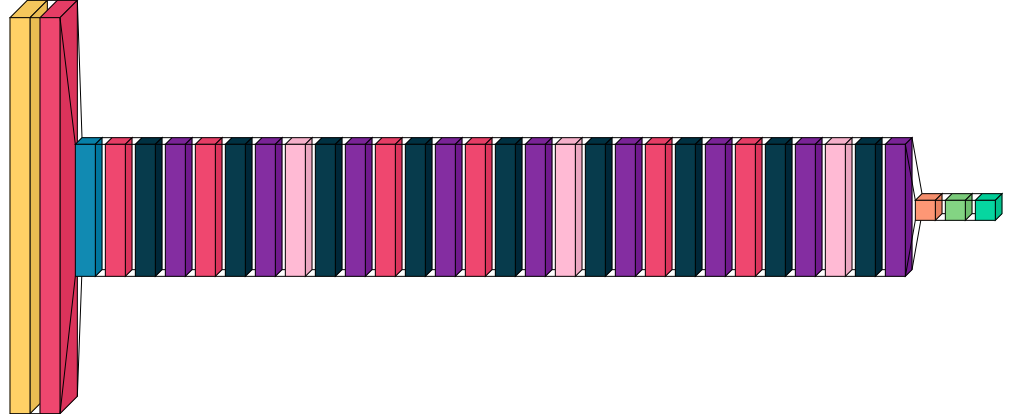

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

resnet8_m=resnet8(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(resnet8_m.summary())
visualkeras.layered_view(resnet8_m)

In [ ]:
resnet8_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_resnet8_m=resnet8_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 391s 303ms/step - loss: 2.5205 - sparse_categorical_accuracy: 0.3521 - val_loss: 1.7899 - val_sparse_categorical_accuracy: 0.5118
Epoch 2/25
497/497 [==============================] - 73s 148ms/step - loss: 1.3963 - sparse_categorical_accuracy: 0.6270 - val_loss: 1.2816 - val_sparse_categorical_accuracy: 0.6452
Epoch 3/25
497/497 [==============================] - 77s 155ms/step - loss: 1.0433 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.9759 - val_sparse_categorical_accuracy: 0.7276
Epoch 4/25
497/497 [==============================] - 72s 146ms/step - loss: 0.8912 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.7384
Epoch 5/25
497/497 [==============================] - 72s 146ms/step - loss: 0.8043 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.8573 - val_sparse_categorical_accuracy: 0.7574
Epoch 6/25
497/497 [==============================] - 72s 145ms/step - loss: 0.7482 

In [ ]:
resnet8_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('resnet8_m_mfcc'))

#resnet8_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('resnet8_m_mfcc'))

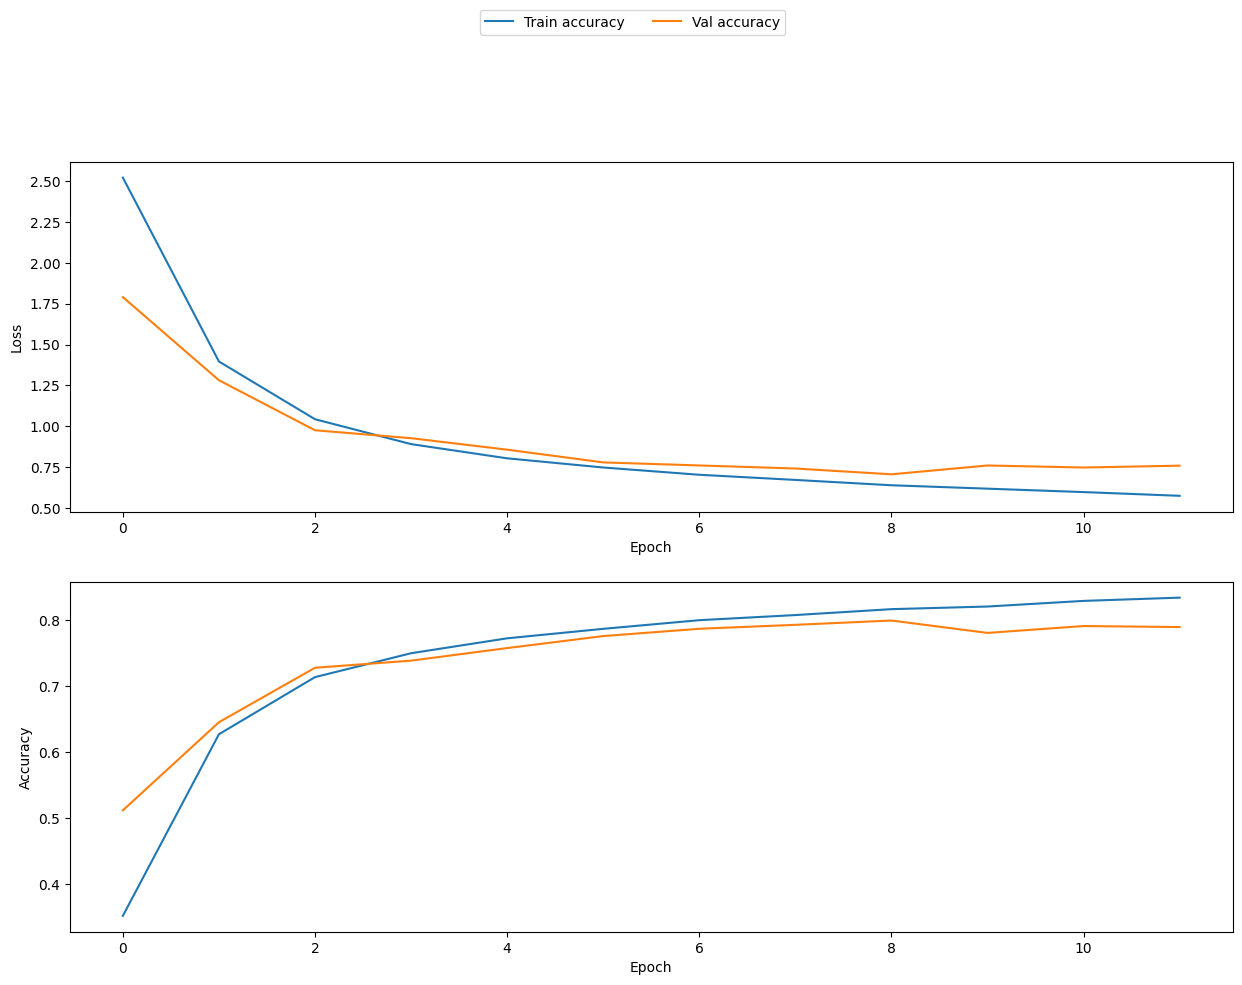

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_resnet8_m.history['loss'], label='Train loss')
axis[0].plot(history_resnet8_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_resnet8_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_resnet8_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=resnet8_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{resnet8_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 81s 486ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.798932,0.782368,0.79962,0.798932,0.788238,0.806155,0.798932,0.801495,0.798932,0.798932,0.782368,resnet8_m


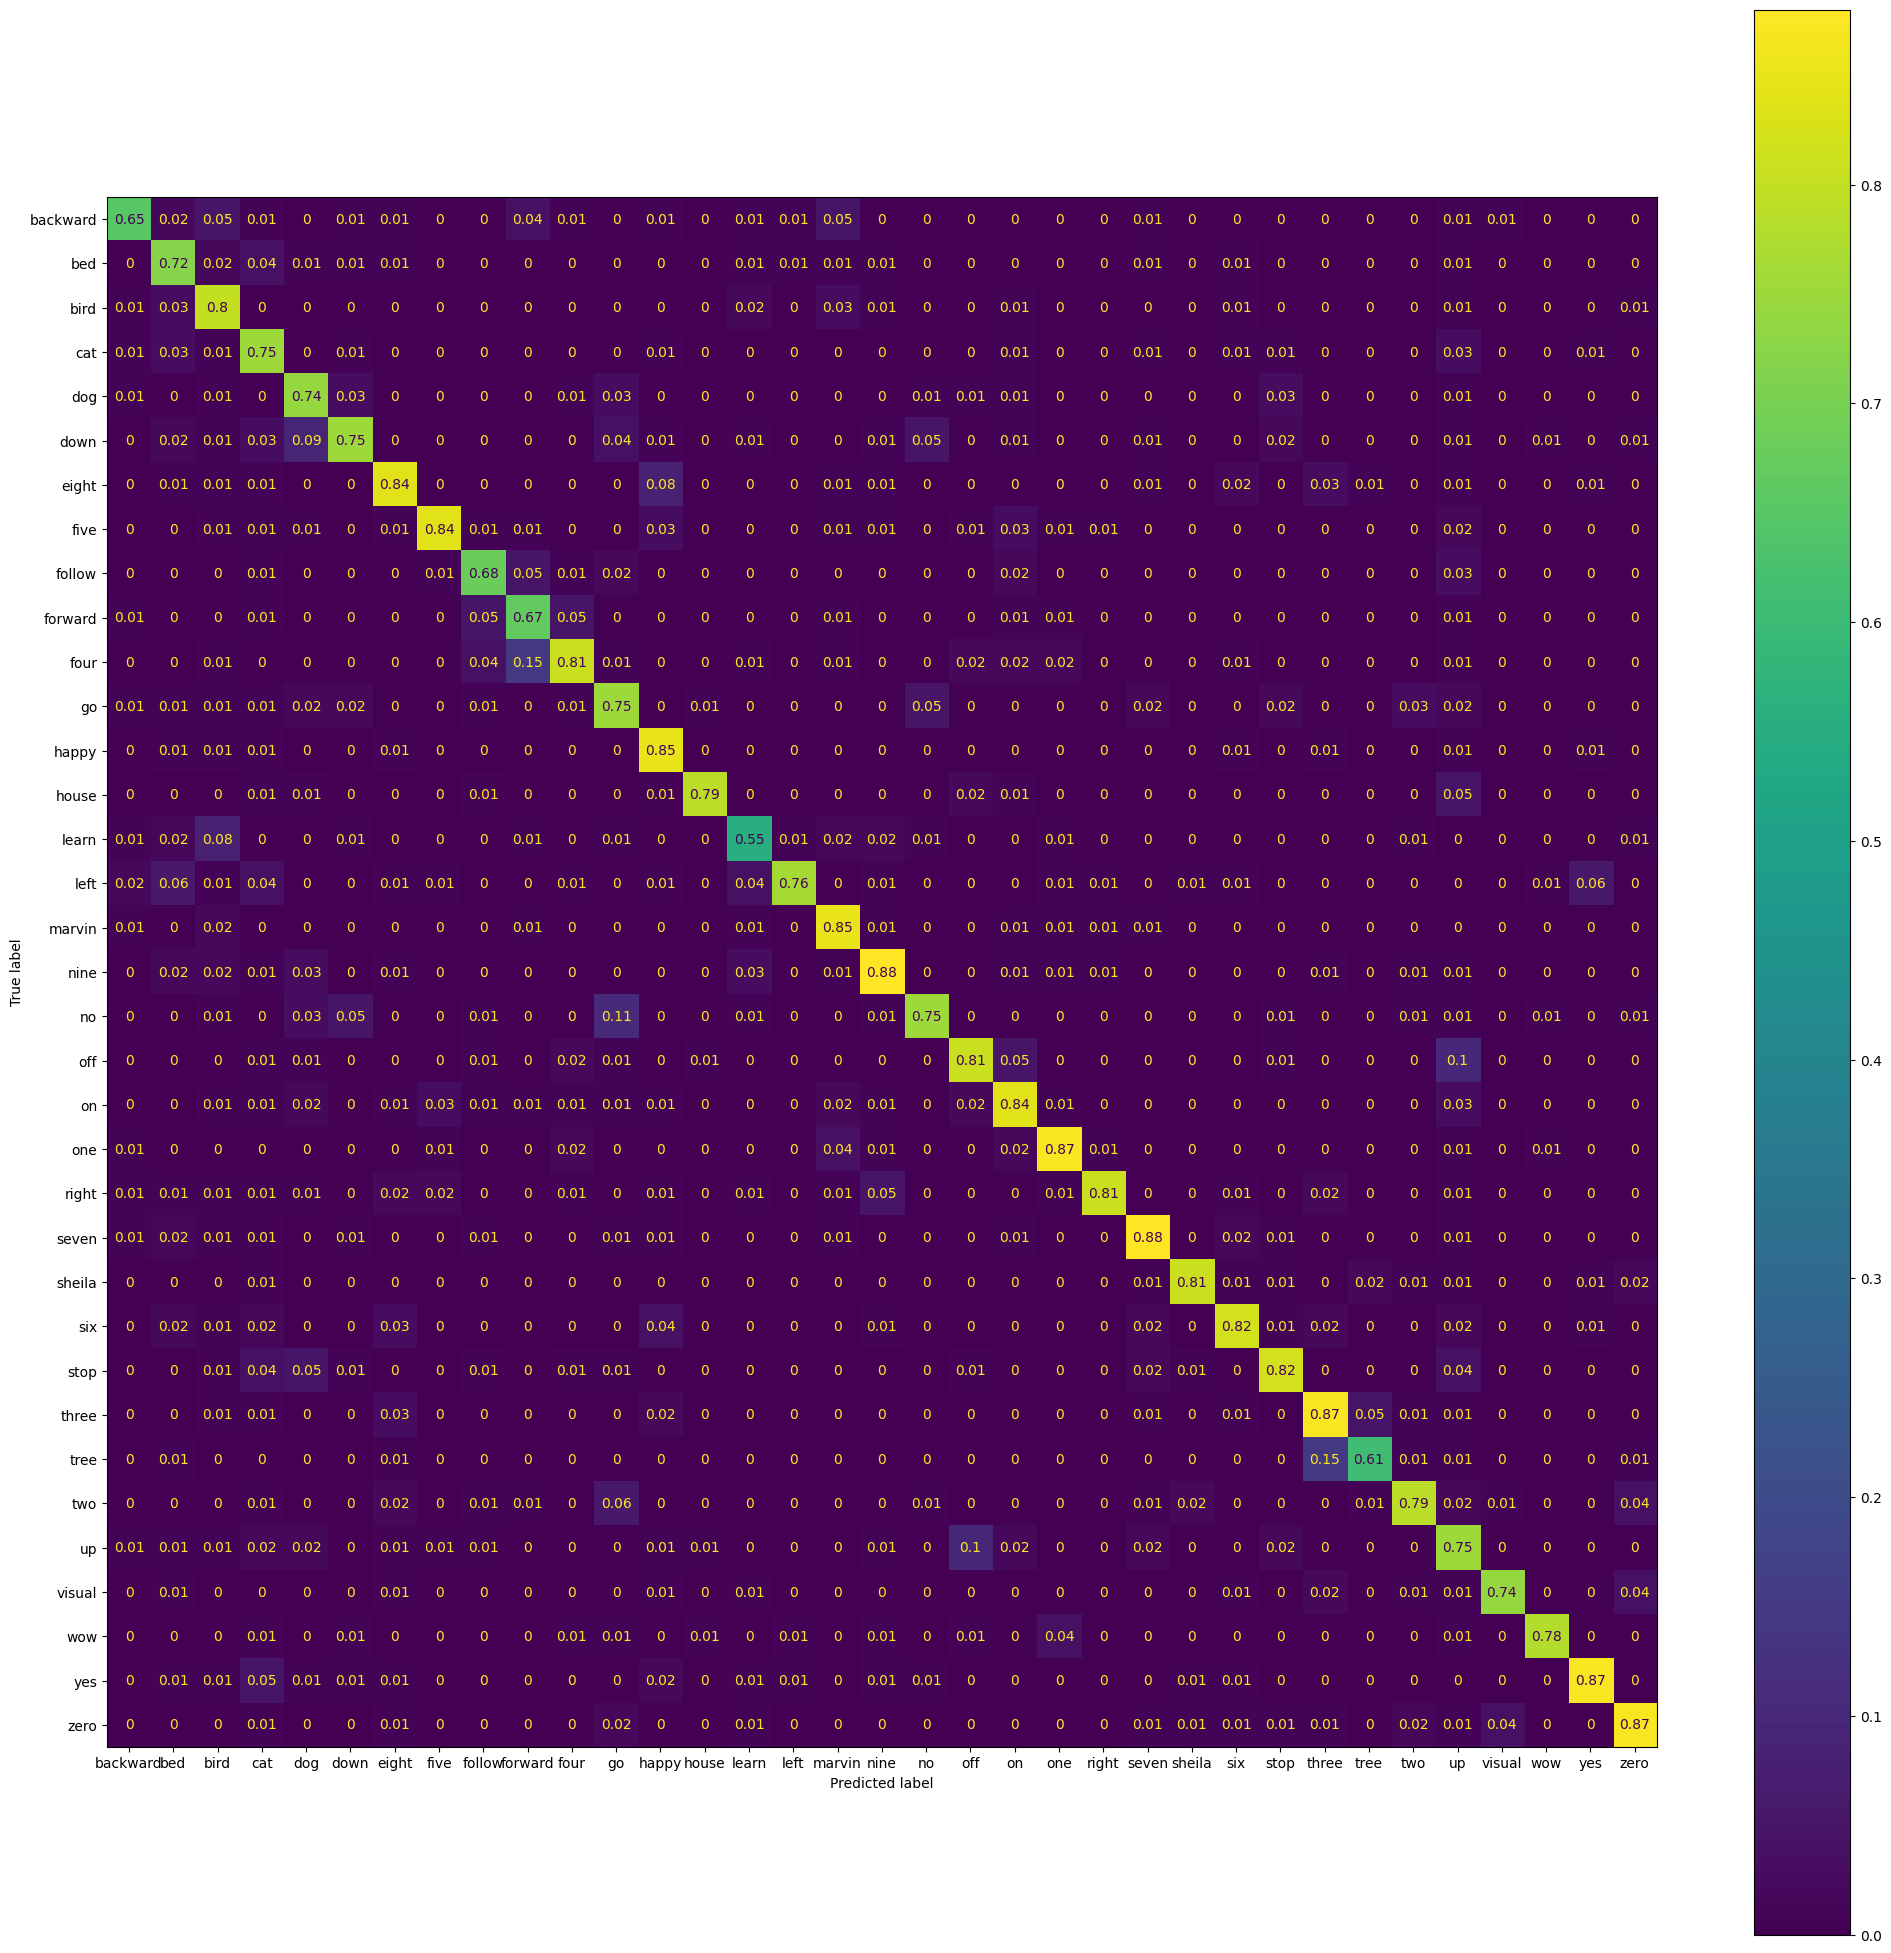

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 7, 50, 8)             328       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 7, 50, 8)             0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 7, 50, 8)             32        ['activation[0][0]']          
 Normalization)                                                                               

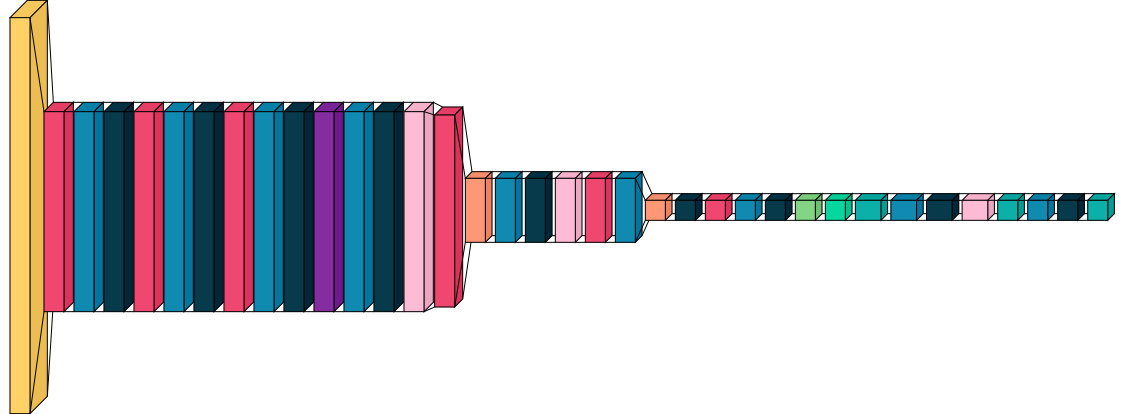

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

CNN_v2_m = CNN_v2(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v2_m.summary())
visualkeras.layered_view(CNN_v2_m)

In [ ]:
CNN_v2_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v2=CNN_v2_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 93s 180ms/step - loss: 2.1286 - sparse_categorical_accuracy: 0.3953 - val_loss: 1.1585 - val_sparse_categorical_accuracy: 0.6588
Epoch 2/25
497/497 [==============================] - 91s 183ms/step - loss: 1.0684 - sparse_categorical_accuracy: 0.6814 - val_loss: 0.7866 - val_sparse_categorical_accuracy: 0.7627
Epoch 3/25
497/497 [==============================] - 92s 185ms/step - loss: 0.8502 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.6792 - val_sparse_categorical_accuracy: 0.7972
Epoch 4/25
497/497 [==============================] - 93s 187ms/step - loss: 0.7448 - sparse_categorical_accuracy: 0.7751 - val_loss: 0.6199 - val_sparse_categorical_accuracy: 0.8113
Epoch 5/25
497/497 [==============================] - 88s 177ms/step - loss: 0.6850 - sparse_categorical_accuracy: 0.7939 - val_loss: 0.5749 - val_sparse_categorical_accuracy: 0.8265
Epoch 6/25
497/497 [==============================] - 89s 178ms/step - loss: 0.6368 -

In [ ]:
CNN_v2_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('CNN_v2_mfcc'))
#CNN_v2_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('CNN_v2_mfcc'))

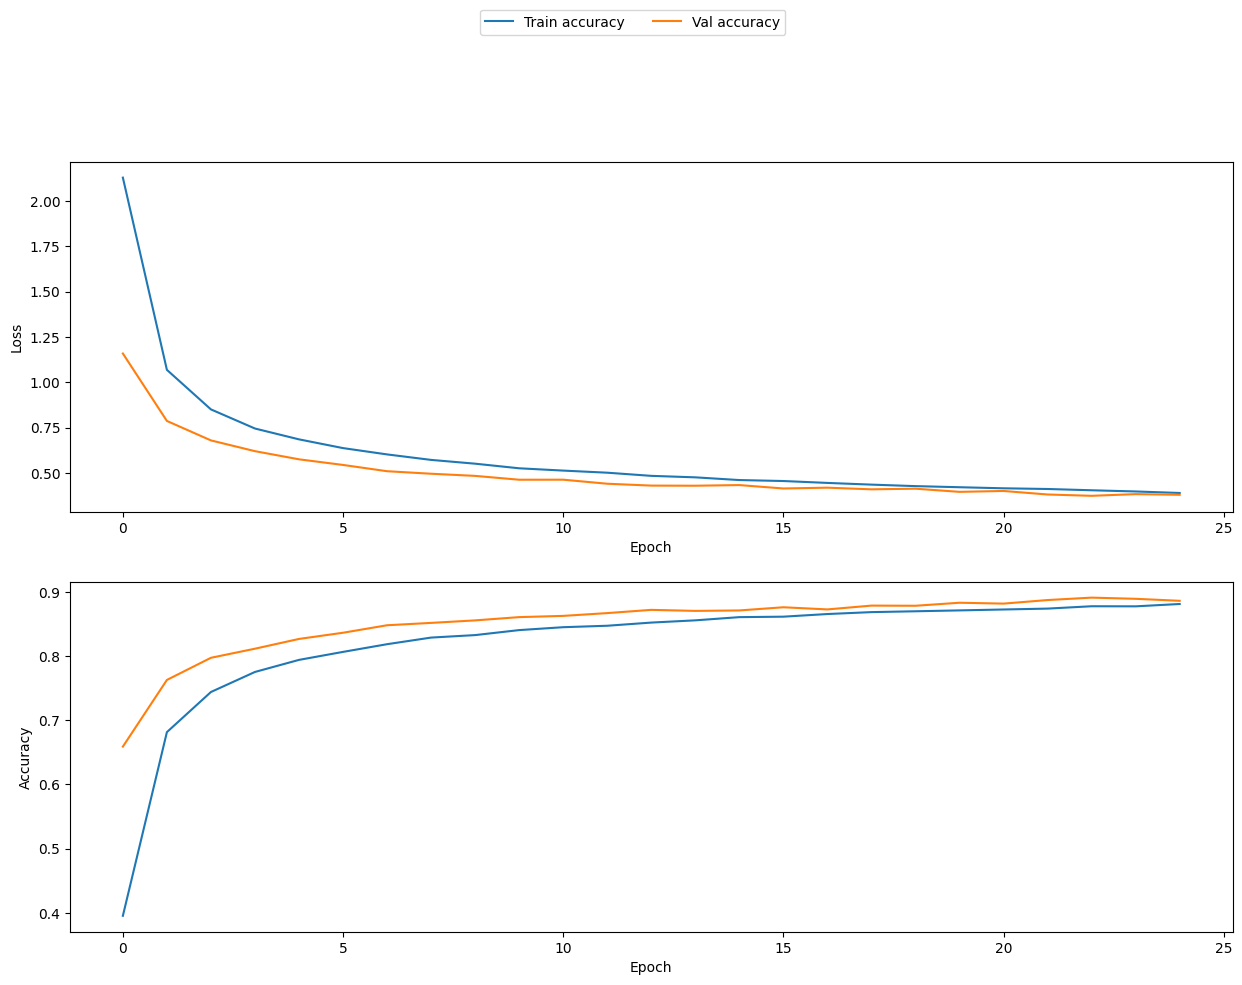

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v2.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v2.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v2.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v2.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=CNN_v2_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v2_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 8s 48ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.798932,0.782368,0.799620,0.798932,0.788238,0.806155,0.798932,0.801495,0.798932,0.798932,0.782368,resnet8_m
1,0.886238,0.874314,0.886914,0.886238,0.880373,0.891026,0.886238,0.890794,0.886238,0.886238,0.874314,CNN_v2_m


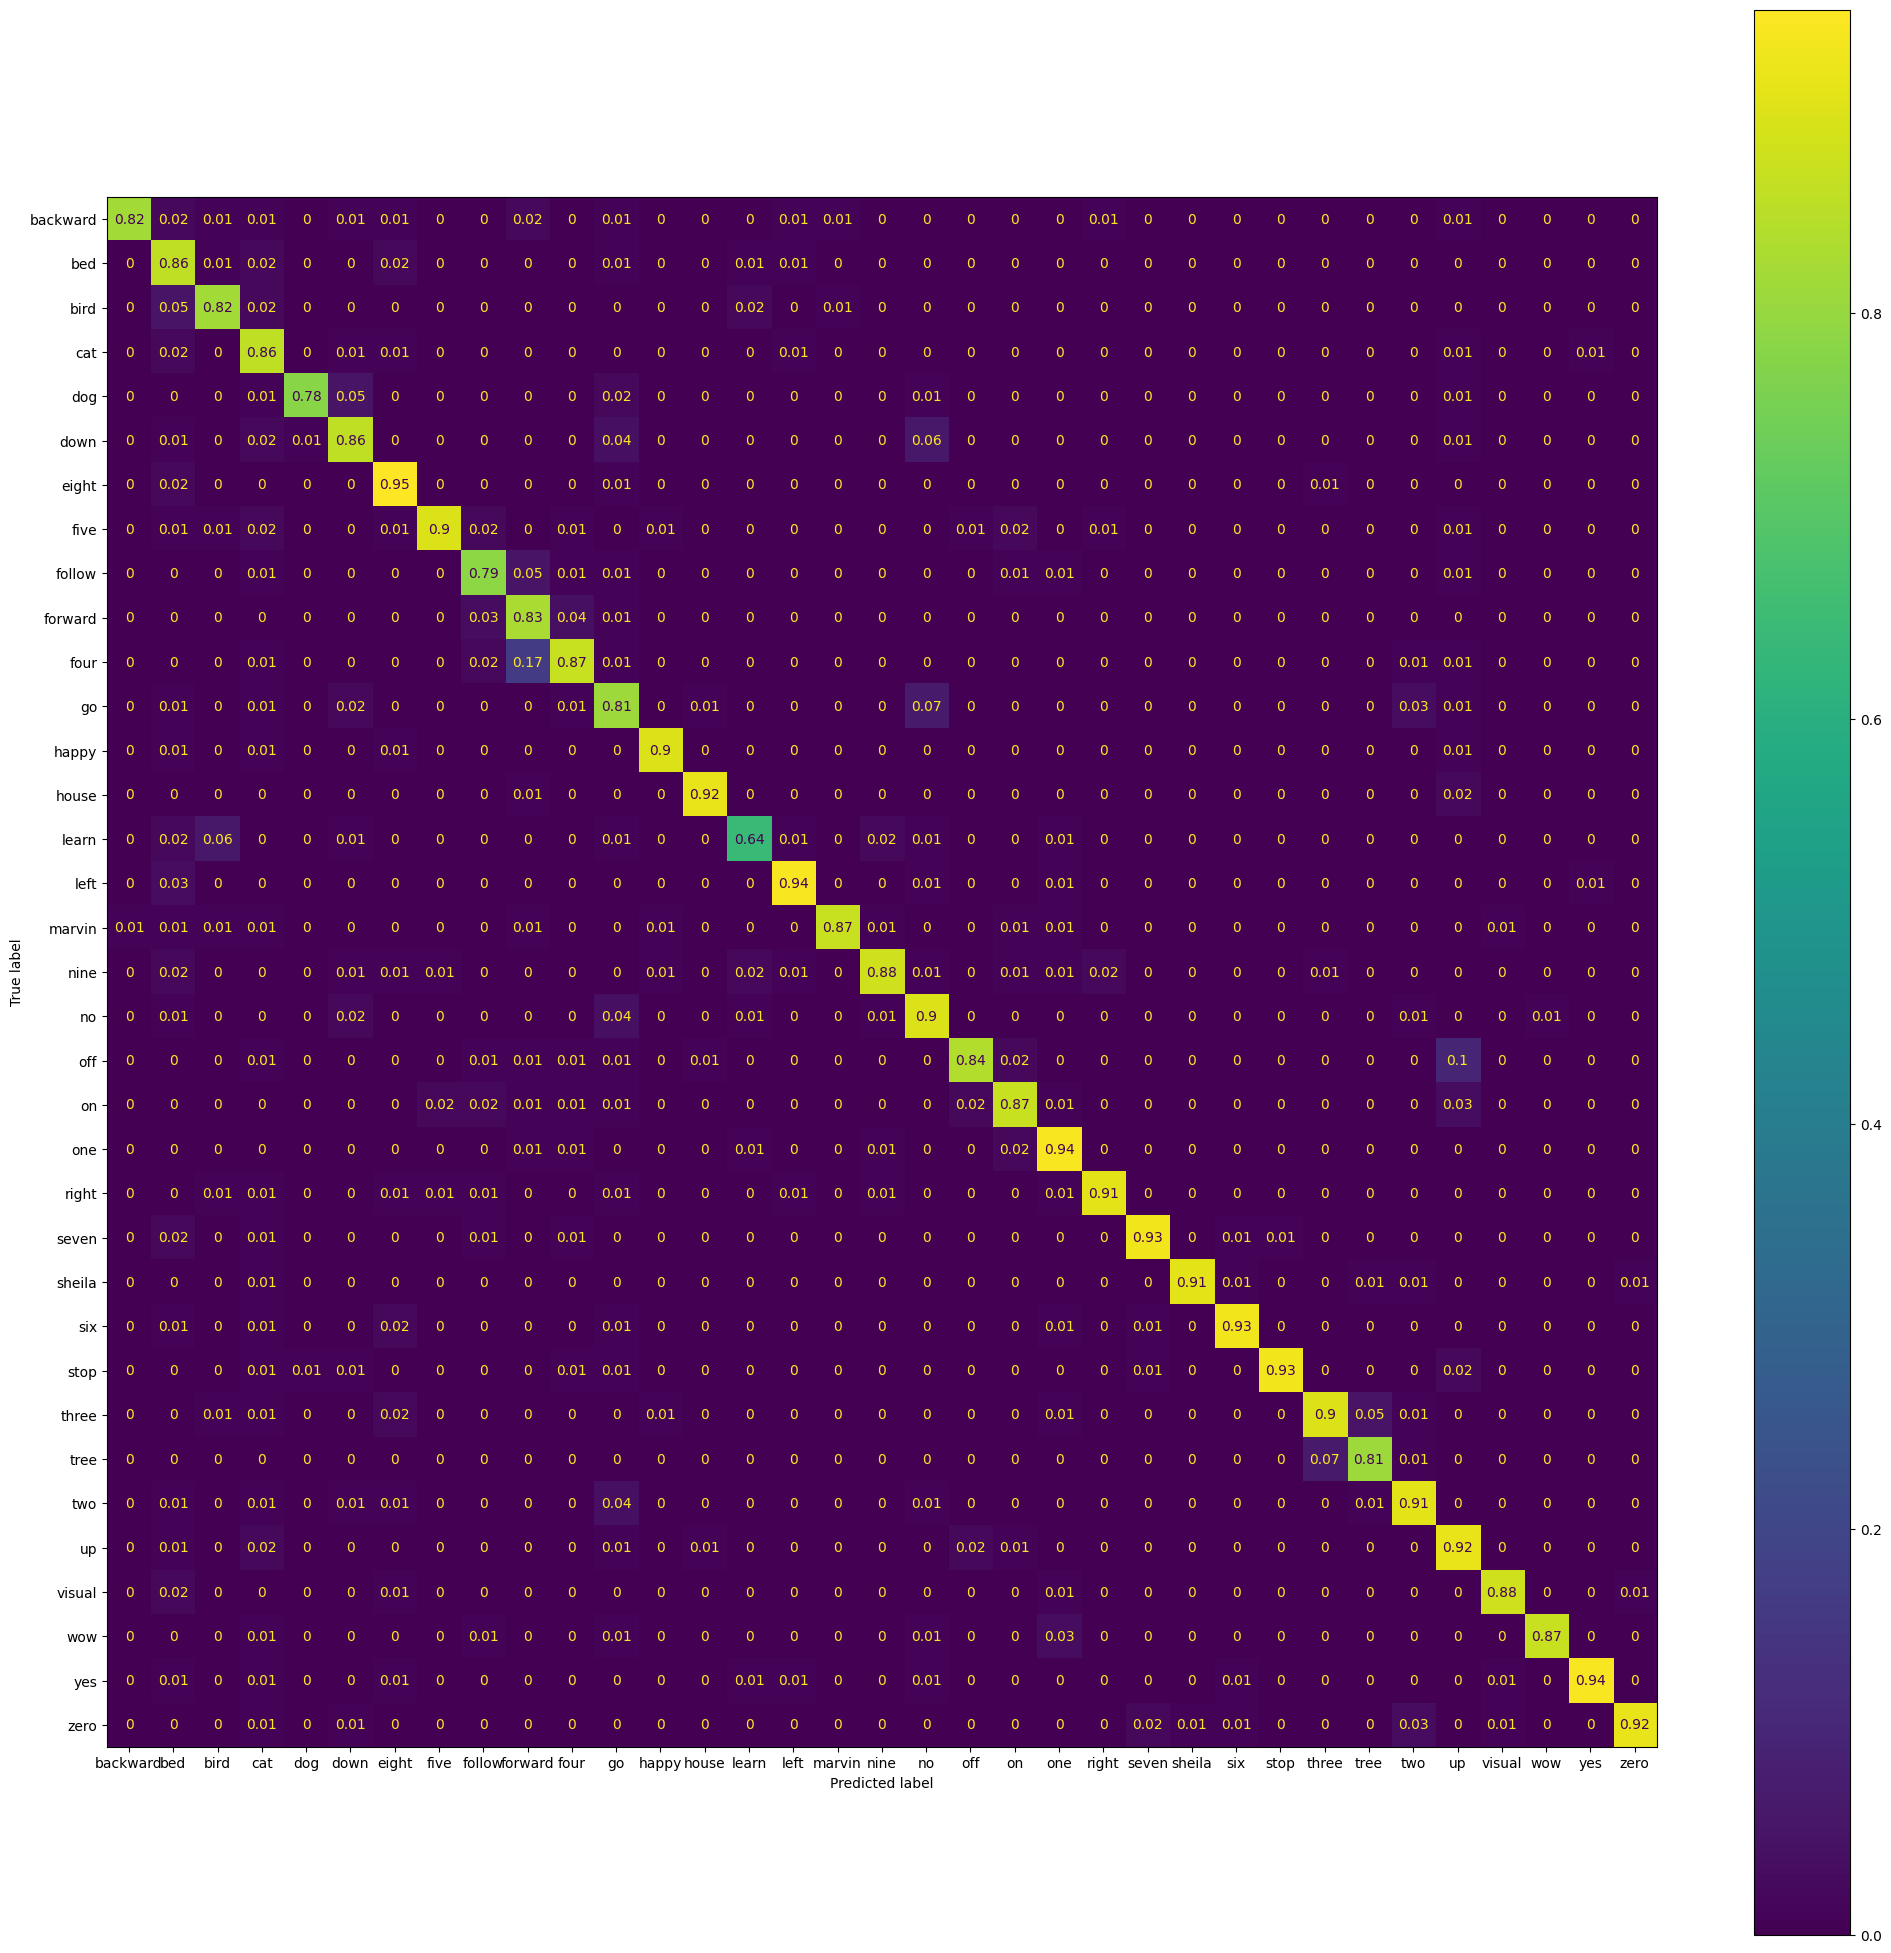

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 99, 8)            136       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 13, 99, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 average_pooling2d (Average  (None, 6, 33, 8)             0         ['activation[0][0]']          
 Pooling2D)                                                                                   

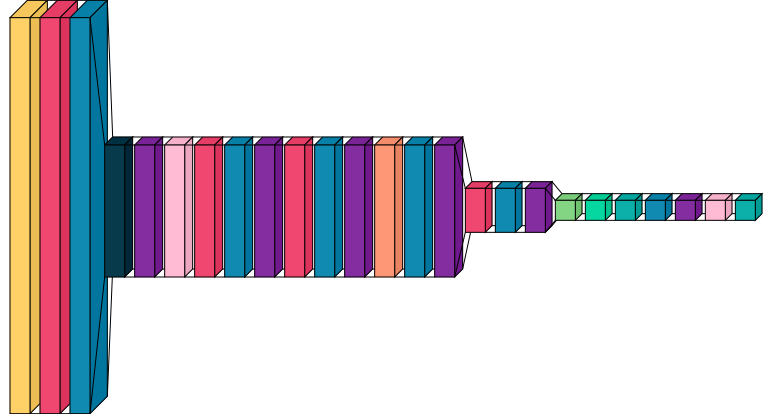

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

CNN_v3_m=CNN_v3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v3_m.summary())
visualkeras.layered_view(CNN_v3_m)

In [ ]:
CNN_v3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v3=CNN_v3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 67s 128ms/step - loss: 2.3824 - sparse_categorical_accuracy: 0.3399 - val_loss: 1.5079 - val_sparse_categorical_accuracy: 0.5899
Epoch 2/25
497/497 [==============================] - 62s 124ms/step - loss: 1.3349 - sparse_categorical_accuracy: 0.6149 - val_loss: 1.0939 - val_sparse_categorical_accuracy: 0.6791
Epoch 3/25
497/497 [==============================] - 62s 125ms/step - loss: 1.0810 - sparse_categorical_accuracy: 0.6861 - val_loss: 0.9073 - val_sparse_categorical_accuracy: 0.7325
Epoch 4/25
497/497 [==============================] - 63s 126ms/step - loss: 0.9561 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7935 - val_sparse_categorical_accuracy: 0.7657
Epoch 5/25
497/497 [==============================] - 64s 128ms/step - loss: 0.8793 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.7664 - val_sparse_categorical_accuracy: 0.7721
Epoch 6/25
497/497 [==============================] - 64s 128ms/step - loss: 0.8366 -

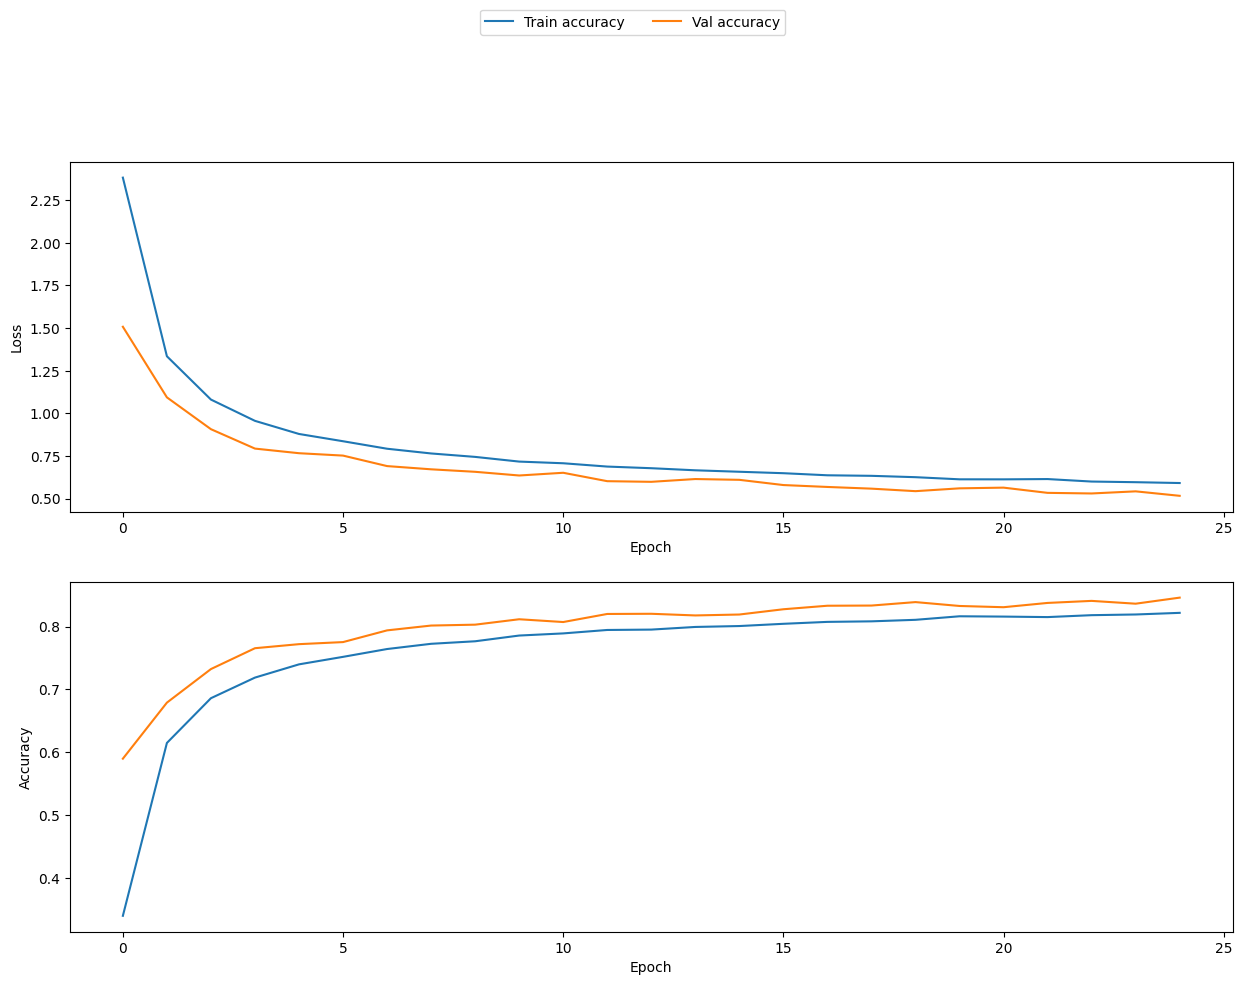

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v3.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
CNN_v3_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('CNN_v3_mfcc'))
#CNN_v3_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('CNN_v3_mfcc'))

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=CNN_v3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 3s 19ms/step


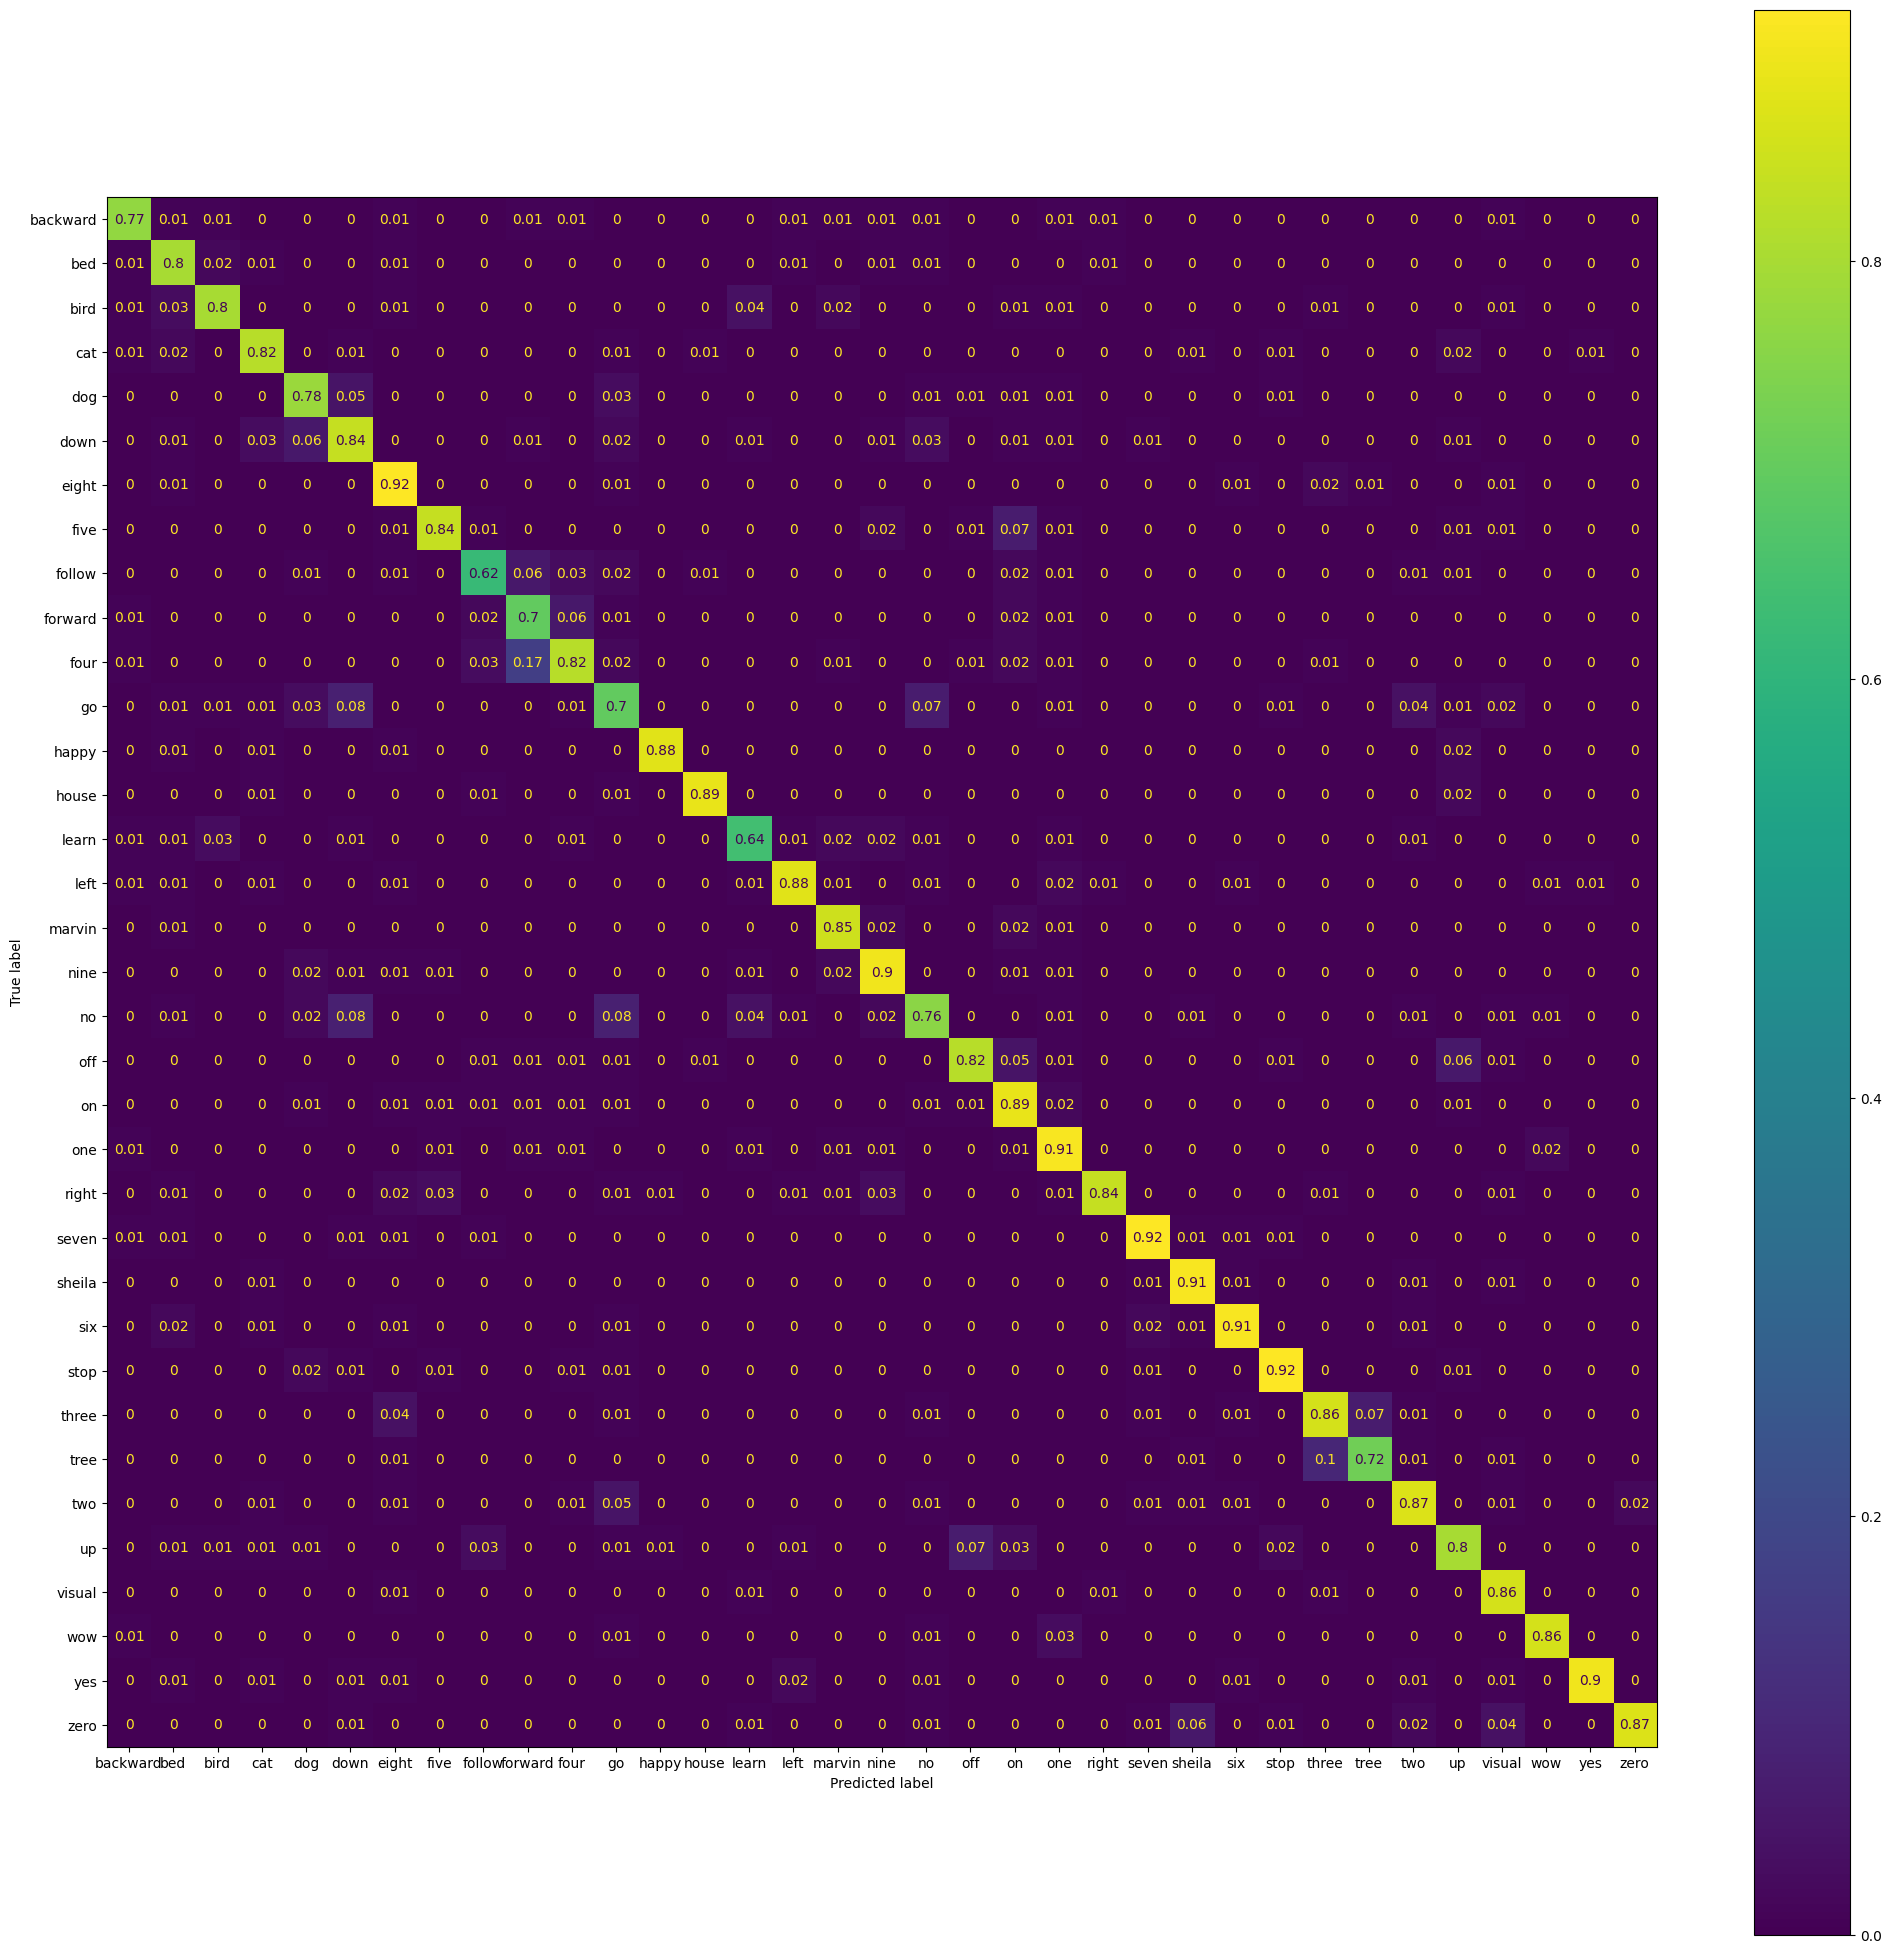

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.798932,0.782368,0.799620,0.798932,0.788238,0.806155,0.798932,0.801495,0.798932,0.798932,0.782368,resnet8_m
1,0.886238,0.874314,0.886914,0.886238,0.880373,0.891026,0.886238,0.890794,0.886238,0.886238,0.874314,CNN_v2_m
2,0.844097,0.830934,0.844051,0.844097,0.837246,0.846977,0.844097,0.847227,0.844097,0.844097,0.830934,CNN_v3_m


**NOISY DATASET**

In [7]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set,train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True,cache_file_value='train_cache', type='mfcc', input_noise=True, simple_mfcc=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc', input_noise=True, simple_mfcc=True)
test_set,test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, shuffle=False ,type='mfcc', testing=True, input_noise=True, simple_mfcc=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 99, 8)            136       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 13, 99, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 average_pooling2d (Average  (None, 6, 33, 8)             0         ['activation[0][0]']          
 Pooling2D)                                                                                   

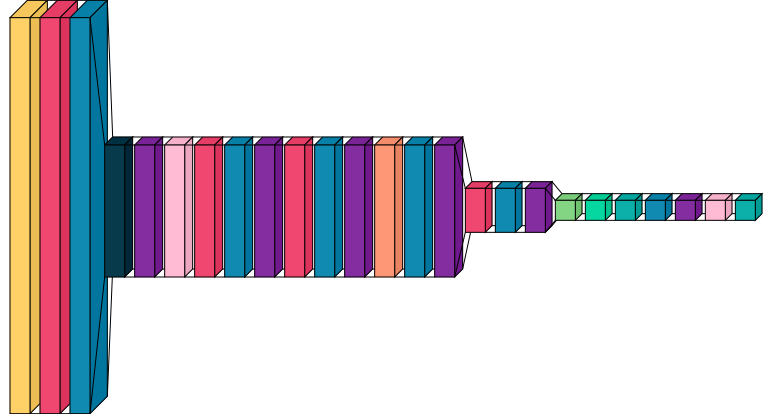

In [8]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

CNN_v3_m=CNN_v3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v3_m.summary())
visualkeras.layered_view(CNN_v3_m)

In [9]:
CNN_v3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v3=CNN_v3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 482s 399ms/step - loss: 2.5522 - sparse_categorical_accuracy: 0.2780 - val_loss: 2.0934 - val_sparse_categorical_accuracy: 0.3896
Epoch 2/25
497/497 [==============================] - 62s 124ms/step - loss: 1.8208 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.6357 - val_sparse_categorical_accuracy: 0.5072
Epoch 3/25
497/497 [==============================] - 62s 124ms/step - loss: 1.5722 - sparse_categorical_accuracy: 0.5308 - val_loss: 1.4429 - val_sparse_categorical_accuracy: 0.5650
Epoch 4/25
497/497 [==============================] - 62s 124ms/step - loss: 1.4405 - sparse_categorical_accuracy: 0.5673 - val_loss: 1.3063 - val_sparse_categorical_accuracy: 0.6083
Epoch 5/25
497/497 [==============================] - 62s 124ms/step - loss: 1.3572 - sparse_categorical_accuracy: 0.5917 - val_loss: 1.1927 - val_sparse_categorical_accuracy: 0.6388
Epoch 6/25
497/497 [==============================] - 61s 124ms/step - loss: 1.2963 

In [10]:
CNN_v3_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('CNN_v3_mfcc'))
#CNN_v3_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('CNN_v3_mfcc'))

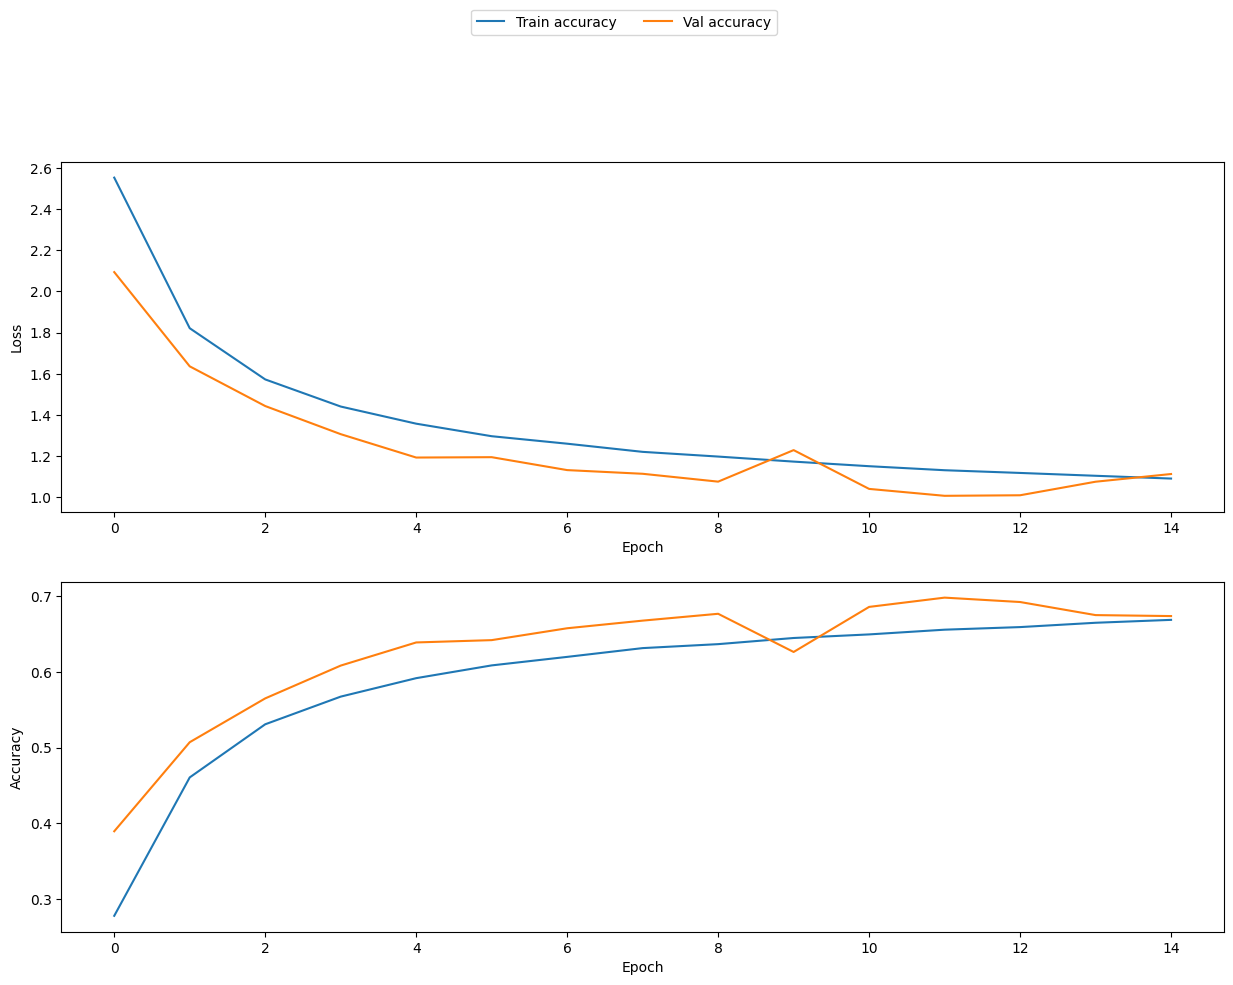

In [11]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_CNN_v3.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]


pred=CNN_v3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v3=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 92s 549ms/step


In [16]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.691737,0.668661,0.690394,0.691737,0.682364,0.706177,0.691737,0.715624,0.691737,0.691737,0.668661,CNN_v3


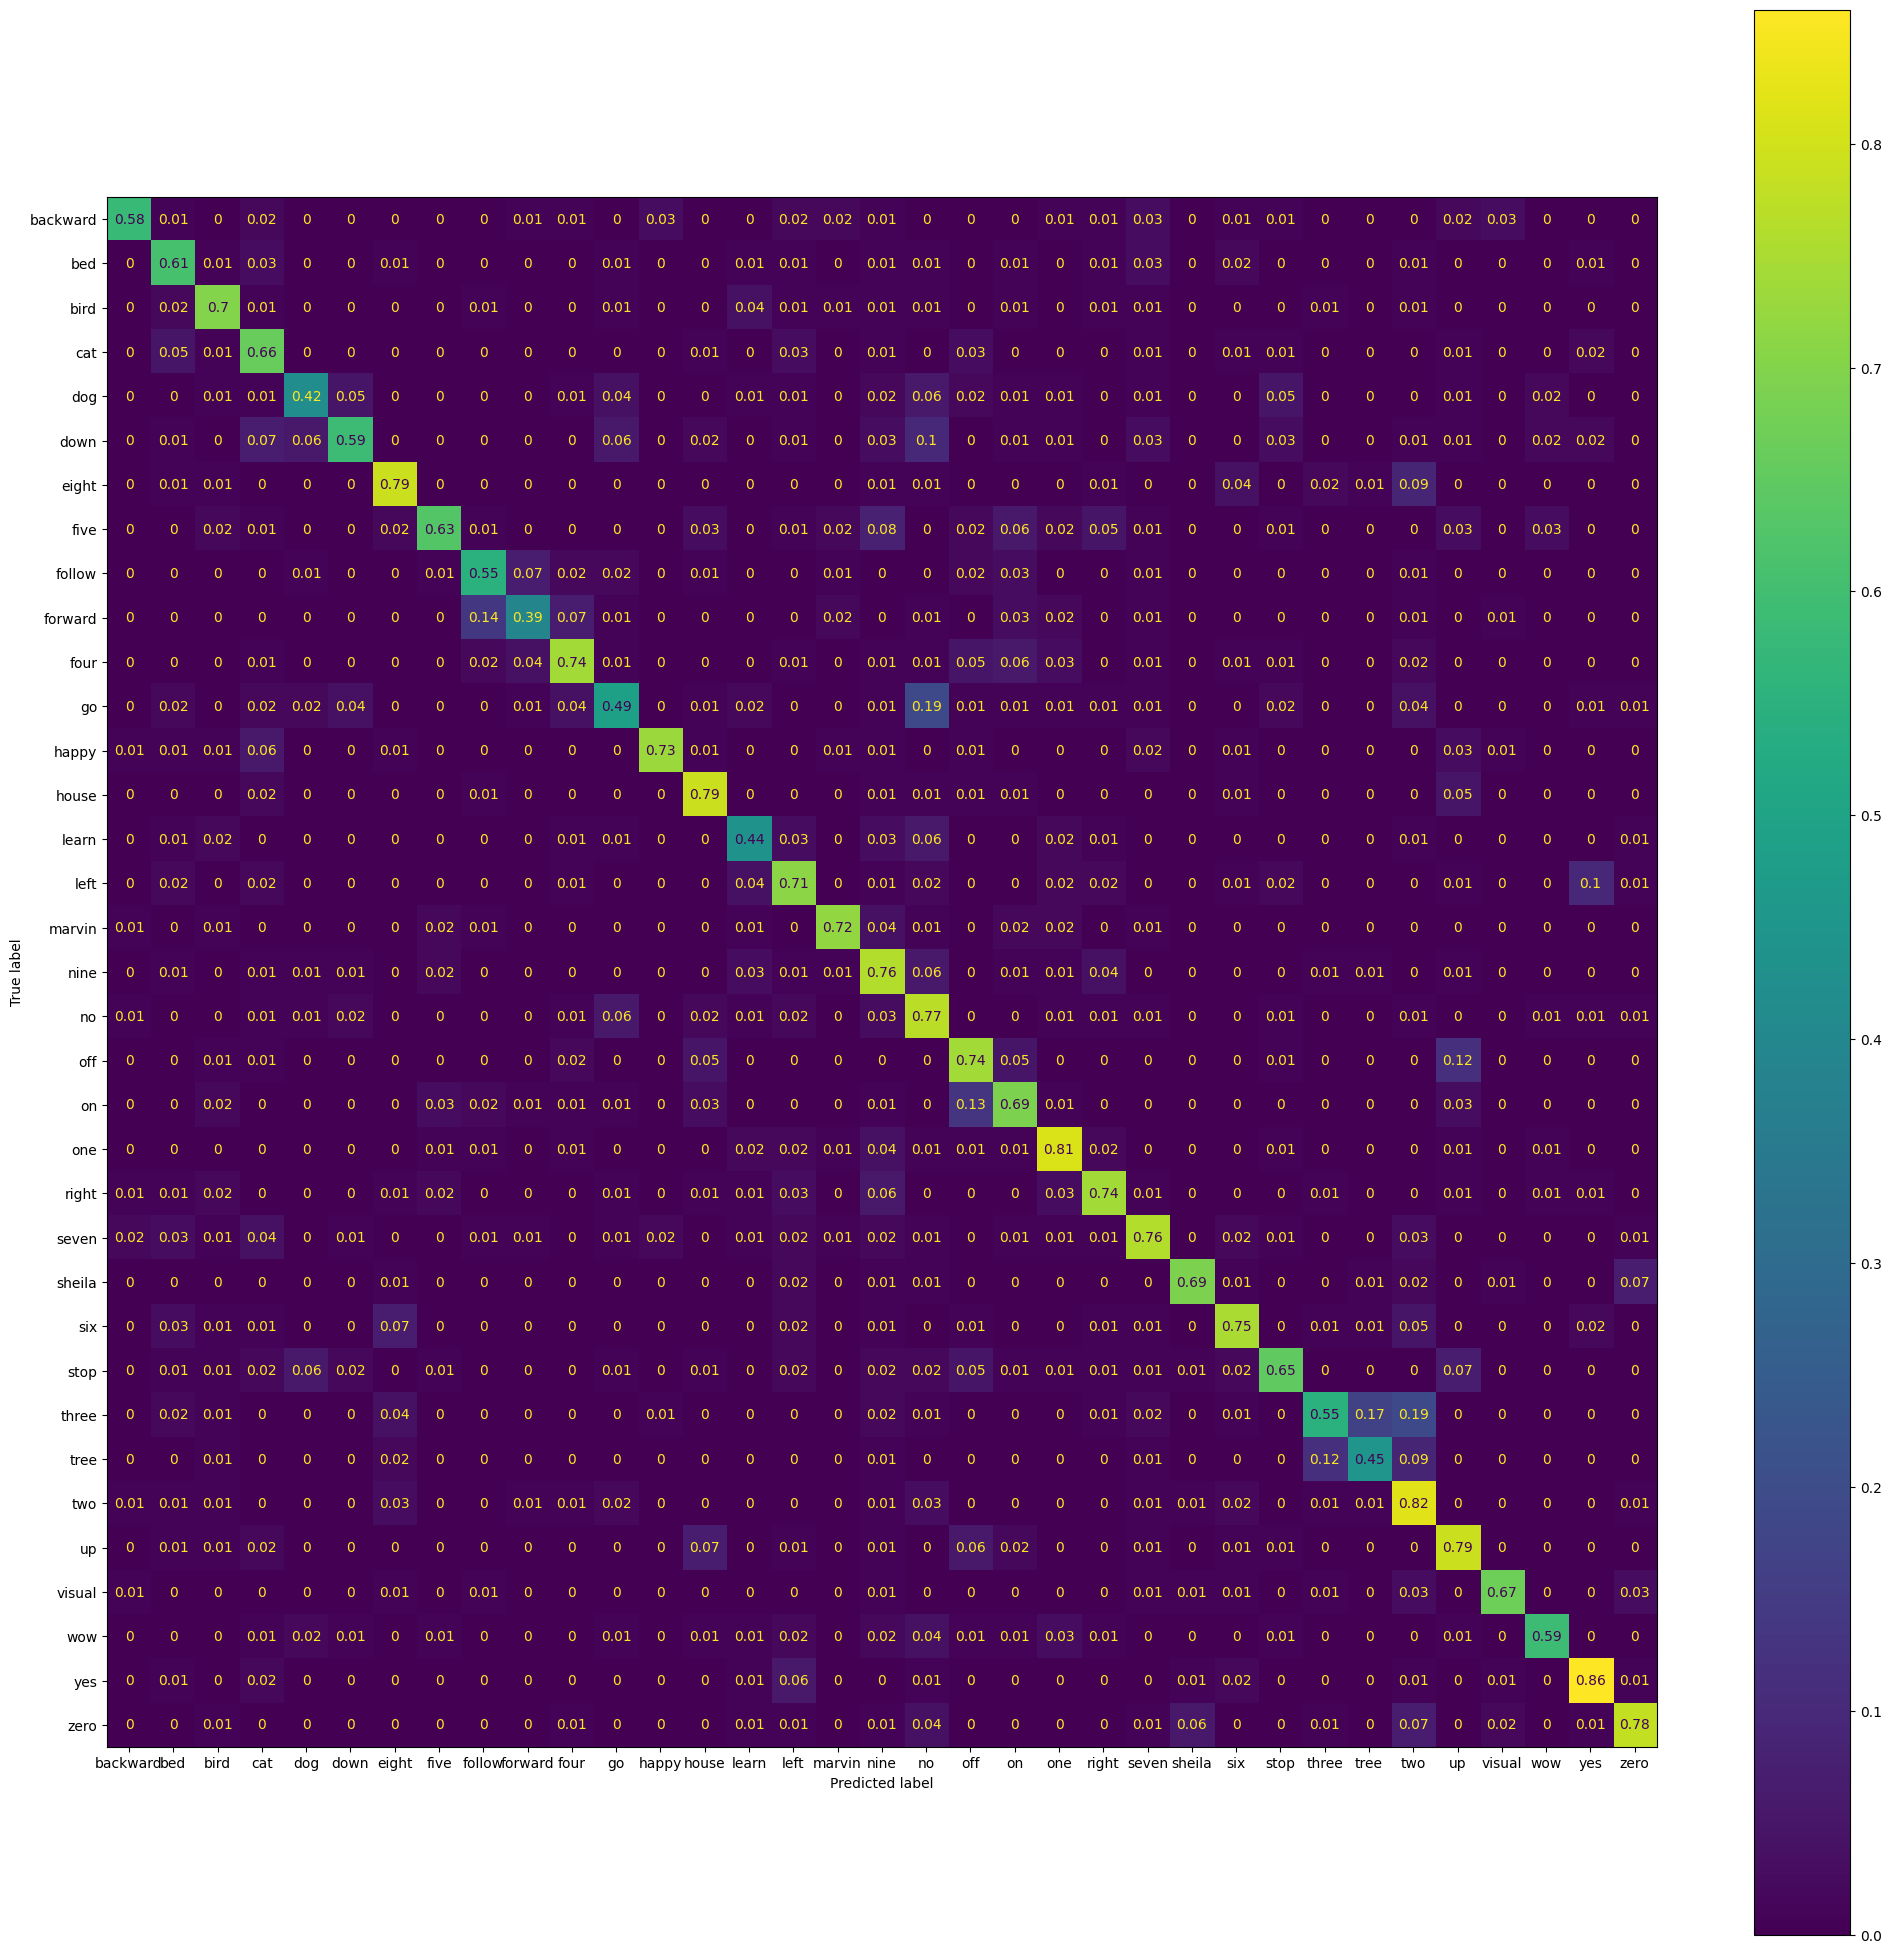

In [13]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 13, 99, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 7, 50, 8)             328       ['input_2[0][0]']             
                                                                                                  
 activation_9 (Activation)   (None, 7, 50, 8)             0         ['conv2d_6[0][0]']            
                                                                                                  
 batch_normalization_9 (Bat  (None, 7, 50, 8)             32        ['activation_9[0][0]']        
 chNormalization)                                                                           

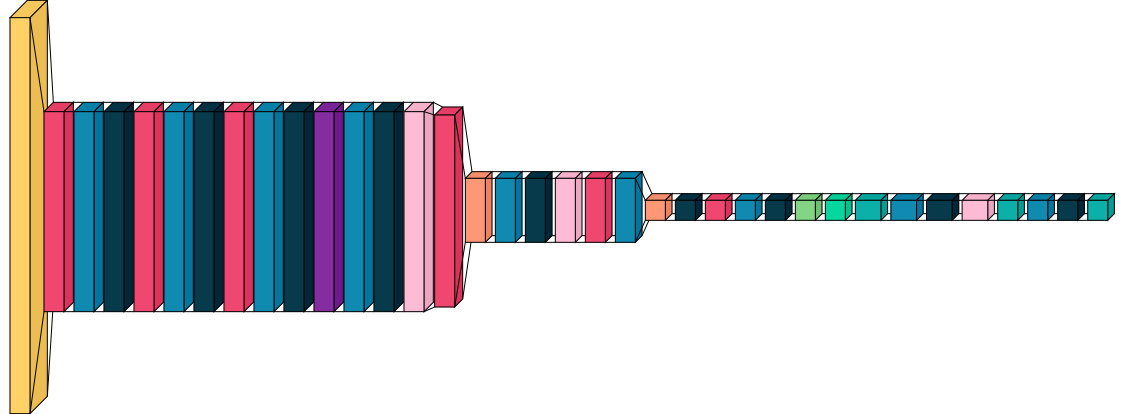

In [19]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

CNN_v2 = CNN_v2(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v2.summary())
visualkeras.layered_view(CNN_v2)

In [20]:
CNN_v2.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v2=CNN_v2.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 124s 248ms/step - loss: 2.5076 - sparse_categorical_accuracy: 0.2858 - val_loss: 1.7962 - val_sparse_categorical_accuracy: 0.4486
Epoch 2/25
497/497 [==============================] - 92s 185ms/step - loss: 1.5641 - sparse_categorical_accuracy: 0.5252 - val_loss: 1.5853 - val_sparse_categorical_accuracy: 0.5387
Epoch 3/25
497/497 [==============================] - 91s 183ms/step - loss: 1.2838 - sparse_categorical_accuracy: 0.6099 - val_loss: 1.5800 - val_sparse_categorical_accuracy: 0.5444
Epoch 4/25
497/497 [==============================] - 86s 172ms/step - loss: 1.1354 - sparse_categorical_accuracy: 0.6553 - val_loss: 1.0638 - val_sparse_categorical_accuracy: 0.6770
Epoch 5/25
497/497 [==============================] - 88s 177ms/step - loss: 1.0474 - sparse_categorical_accuracy: 0.6804 - val_loss: 0.9308 - val_sparse_categorical_accuracy: 0.7177
Epoch 6/25
497/497 [==============================] - 87s 174ms/step - loss: 0.9875 

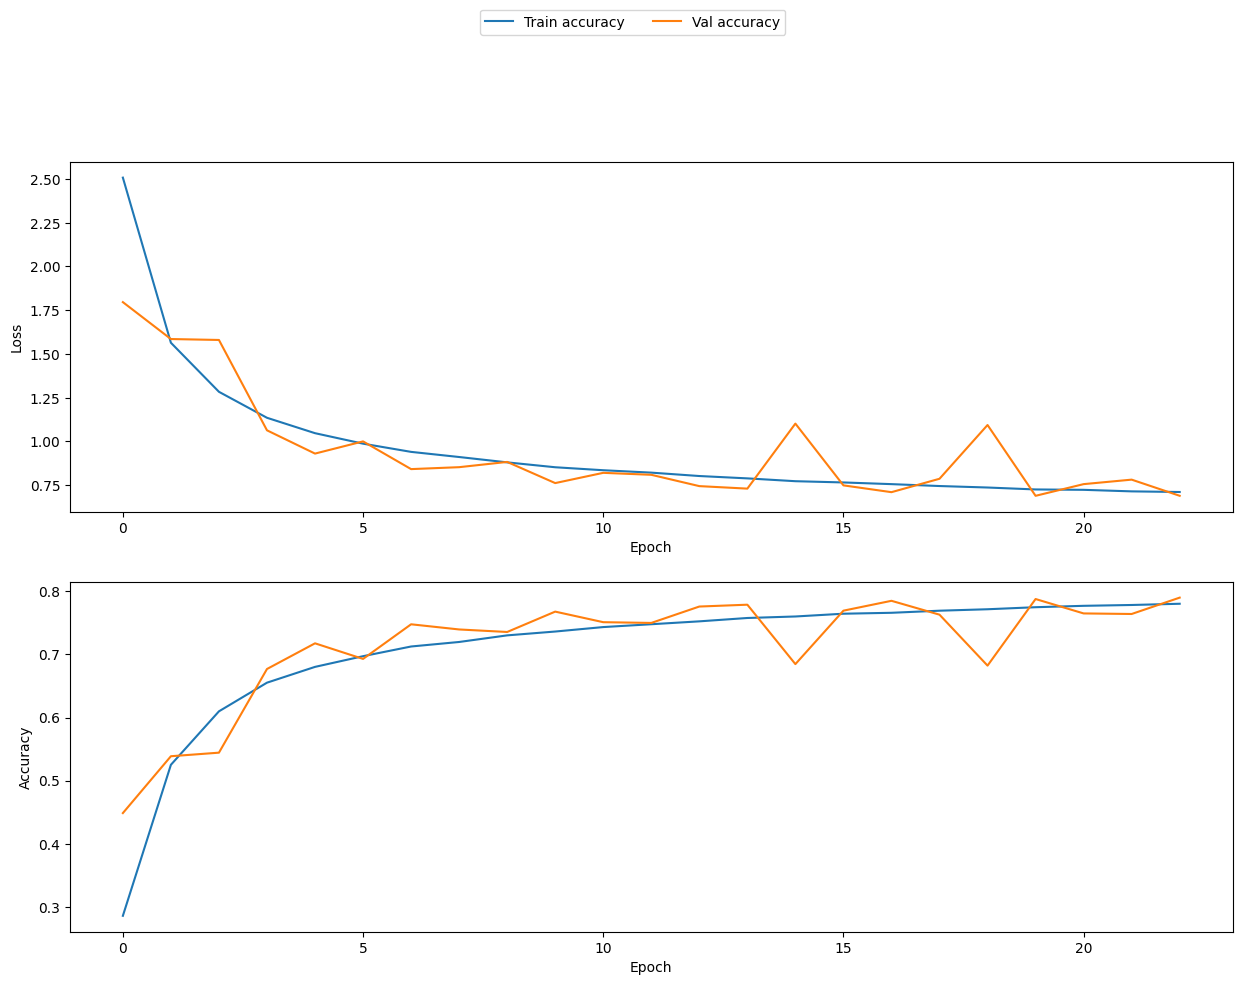

In [21]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v2.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v2.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v2.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v2.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [22]:
CNN_v2.save("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('CNN_v2_mfcc'))
#CNN_v2=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('CNN_v2_mfcc'))

In [23]:

pred=CNN_v2.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v2=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 4s 25ms/step


In [24]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.691737,0.668661,0.690394,0.691737,0.682364,0.706177,0.691737,0.715624,0.691737,0.691737,0.668661,CNN_v3
1,0.789200,0.778738,0.789858,0.789200,0.782090,0.796866,0.789200,0.793010,0.789200,0.789200,0.778738,CNN_v2


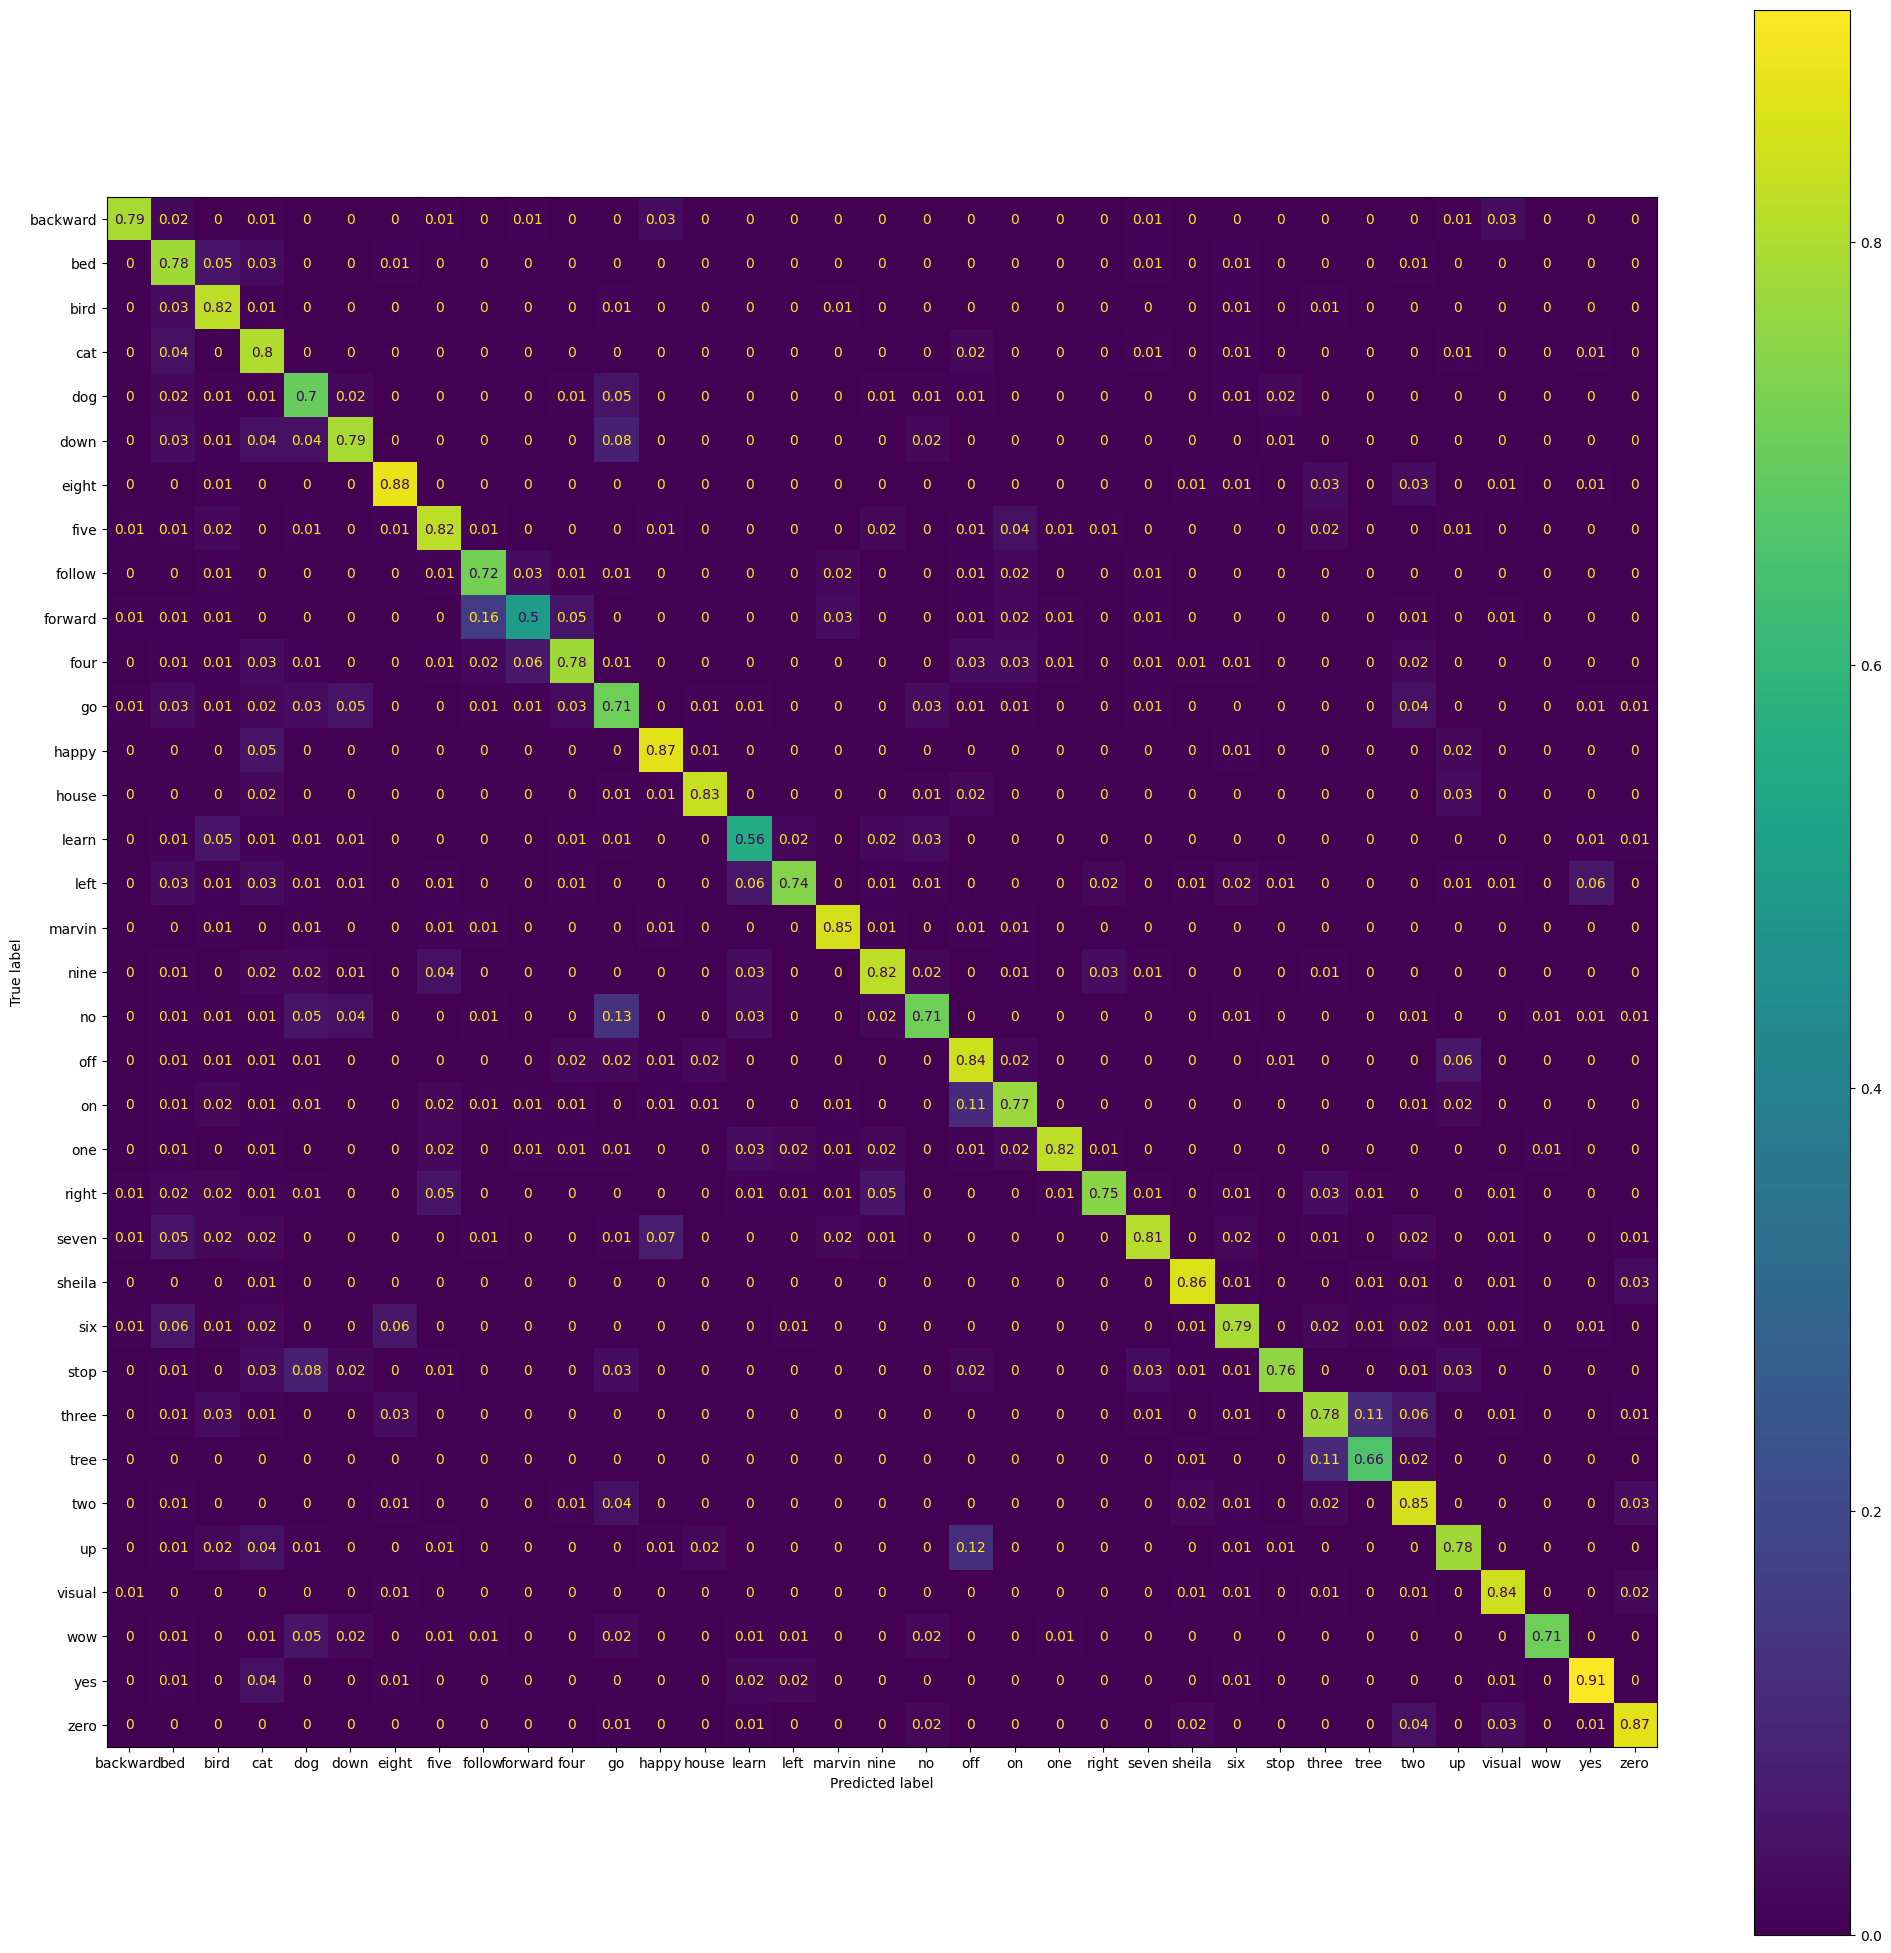

In [25]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 99, 19)           190       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 3, 33, 19)            0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 3, 33, 19)            3268      ['average_pooling2d[0][0]'

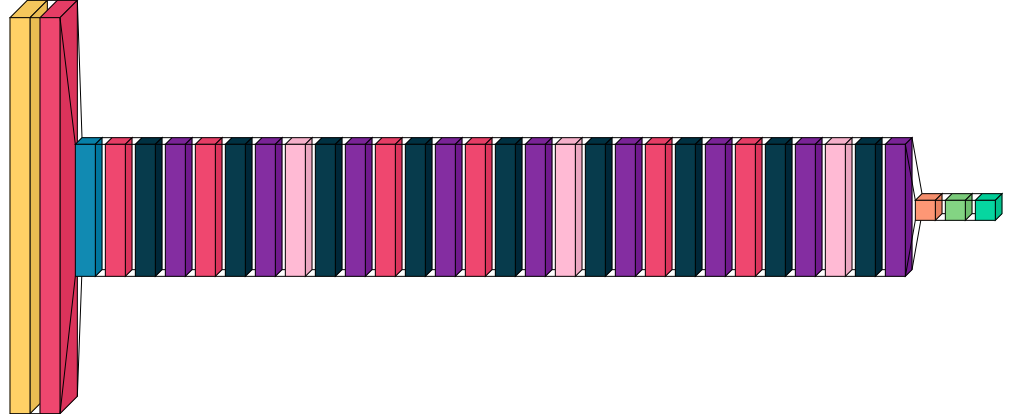

In [26]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

resnet8_m = resnet8(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(resnet8_m.summary())
visualkeras.layered_view(resnet8_m)

In [27]:
resnet8_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_resnet8=resnet8_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 73s 145ms/step - loss: 2.5970 - sparse_categorical_accuracy: 0.3145 - val_loss: 2.4606 - val_sparse_categorical_accuracy: 0.3154
Epoch 2/25
497/497 [==============================] - 72s 145ms/step - loss: 1.5863 - sparse_categorical_accuracy: 0.5596 - val_loss: 1.6411 - val_sparse_categorical_accuracy: 0.5219
Epoch 3/25
497/497 [==============================] - 72s 144ms/step - loss: 1.2259 - sparse_categorical_accuracy: 0.6532 - val_loss: 1.3117 - val_sparse_categorical_accuracy: 0.6282
Epoch 4/25
497/497 [==============================] - 71s 142ms/step - loss: 1.0673 - sparse_categorical_accuracy: 0.6946 - val_loss: 1.2488 - val_sparse_categorical_accuracy: 0.6402
Epoch 5/25
497/497 [==============================] - 72s 146ms/step - loss: 0.9820 - sparse_categorical_accuracy: 0.7153 - val_loss: 1.1232 - val_sparse_categorical_accuracy: 0.6734
Epoch 6/25
497/497 [==============================] - 73s 146ms/step - loss: 0.9159 -

In [28]:
resnet8_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('resnet8_mfcc'))
#resnet8_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('resnet8_mfcc'))

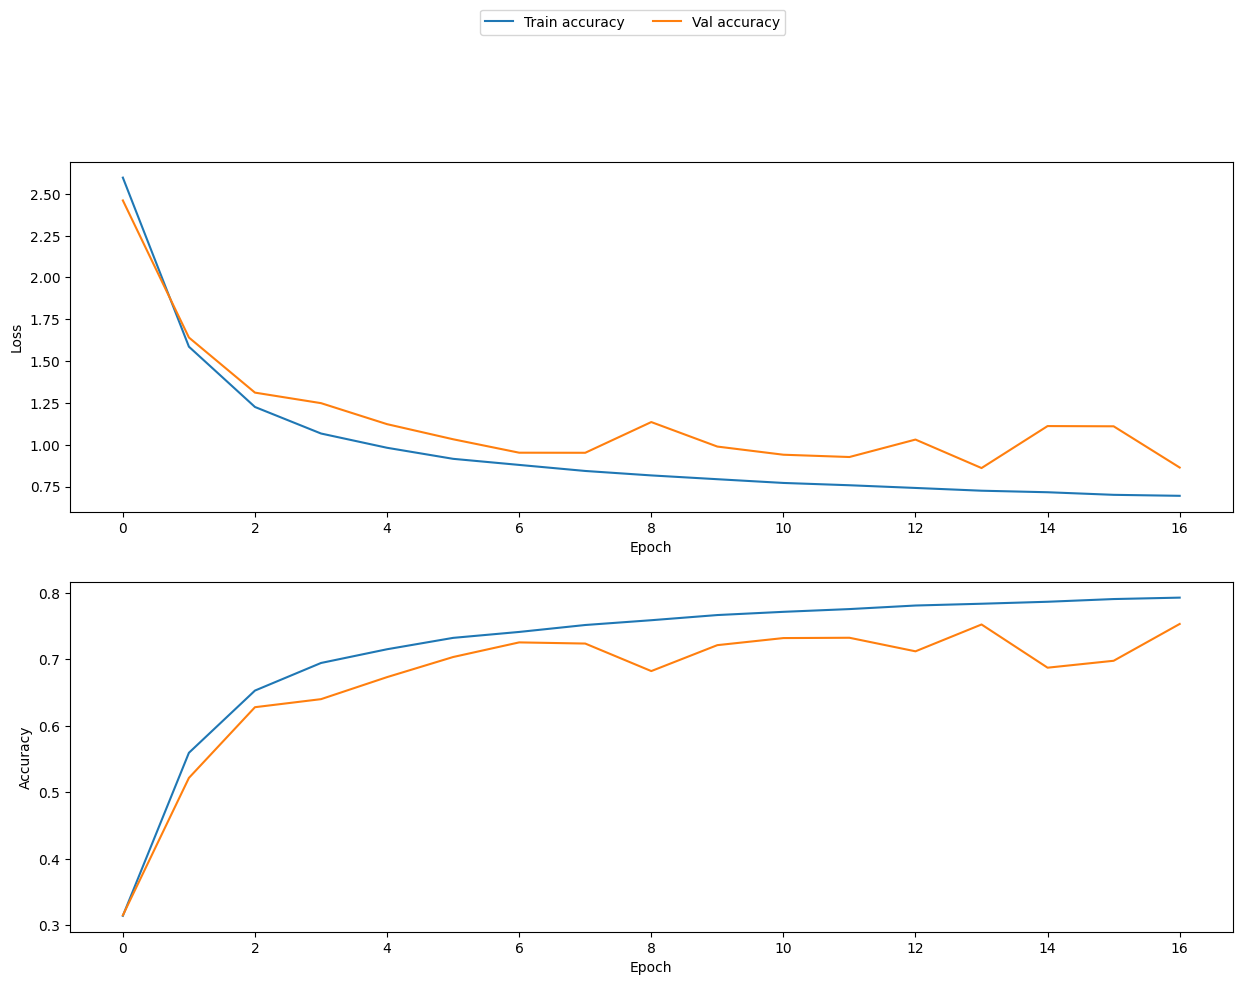

In [29]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_resnet8.history['loss'], label='Train loss')
axis[0].plot(history_resnet8.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_resnet8.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_resnet8.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [30]:

pred=resnet8_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{resnet8_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 4s 26ms/step


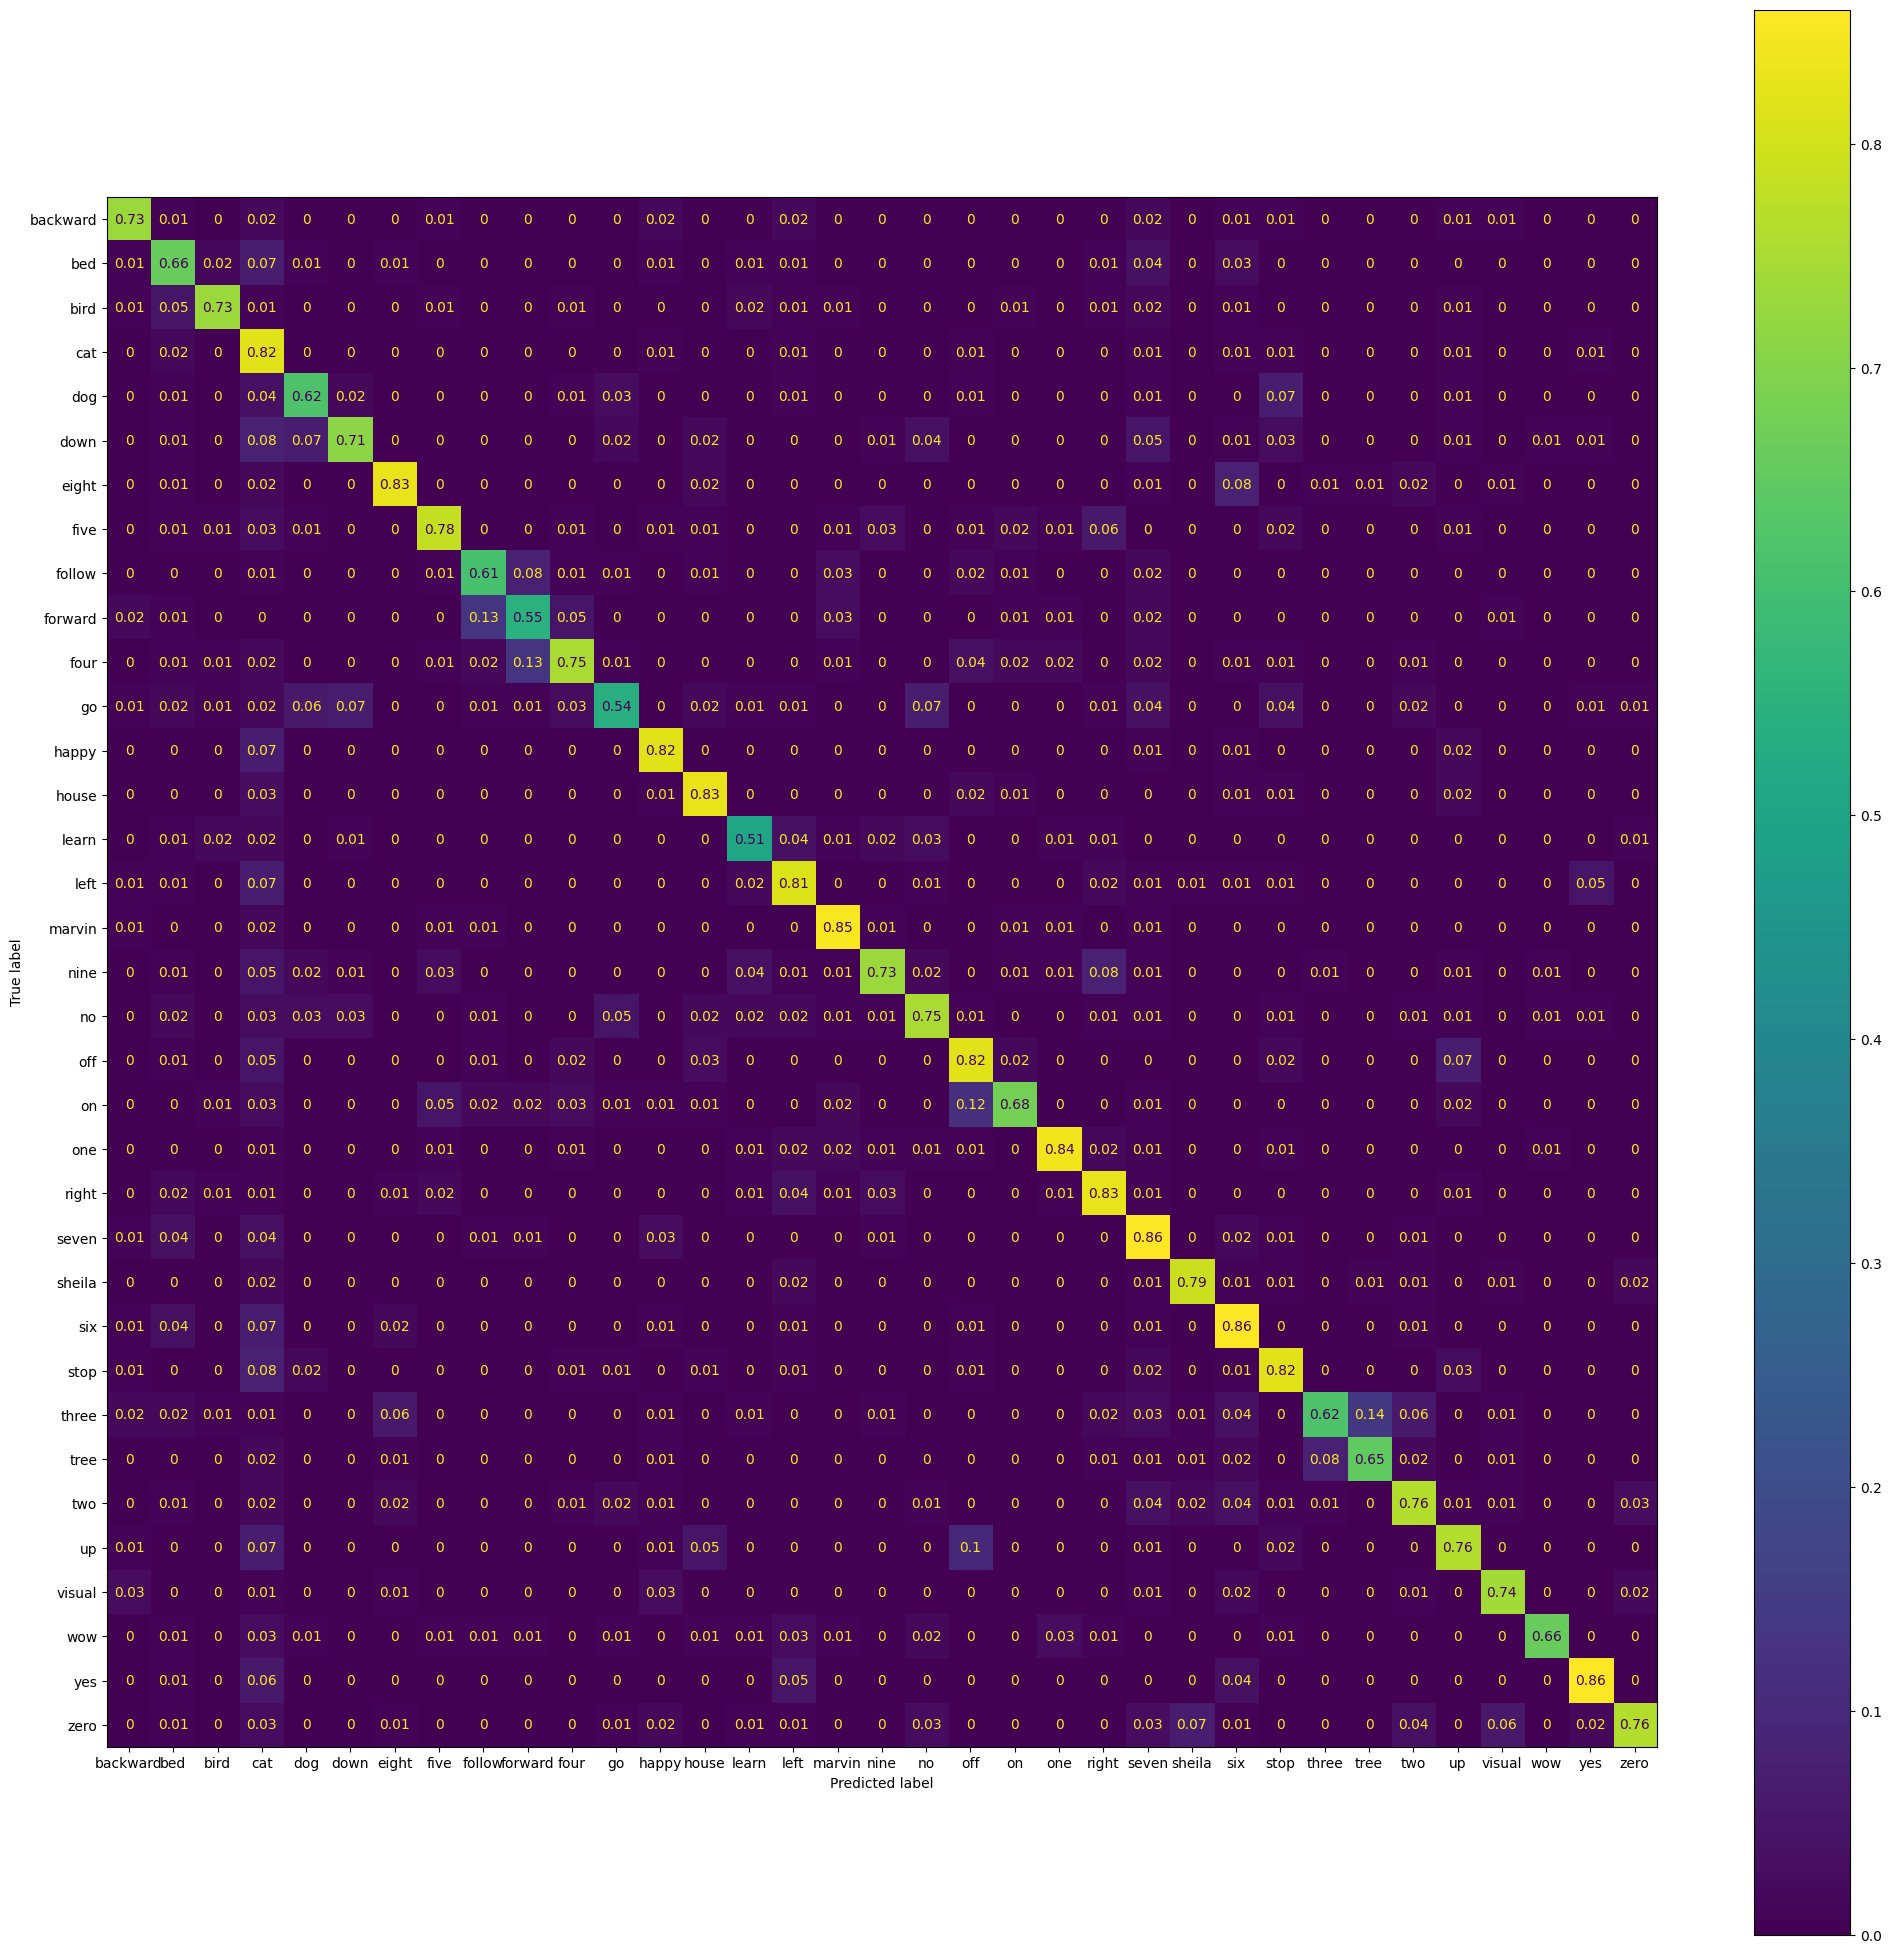

In [31]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [32]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.691737,0.668661,0.690394,0.691737,0.682364,0.706177,0.691737,0.715624,0.691737,0.691737,0.668661,CNN_v3
1,0.789200,0.778738,0.789858,0.789200,0.782090,0.796866,0.789200,0.793010,0.789200,0.789200,0.778738,CNN_v2
2,0.753909,0.740687,0.754659,0.753909,0.745725,0.766940,0.753909,0.763704,0.753909,0.753909,0.740687,resnet8_m
